This notebook should be read with the analysis included in the accompanying report, as well as the output log files that show the results of the tests conducted.

# Importing required packages

In [1]:
import numpy as np
import math
#!pip install prettytable
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Implementation of the Mutli-Layer Perceptron

In [2]:
class MLP:
    # initialising the instance variables for the model
    def __init__(self, i, o, h):
        self.num_inputs = i
        self.num_outputs = o
        self.num_hidden = h
        self.weights_lower = np.array
        self.weights_upper = np.array
        self.weight_changes_lower = np.array
        self.weight_changes_upper = np.array
        self.lower_activations = np.array
        self.upper_activations = np.array
        self.hidden_neurons = np.array
        self.output = np.array
    
    # used to set the initial weights of the model
    # two options, either to use Xavier Weight Initialisation or simply randomise between 0 and 1
    def randomise(self, initialise):
        if initialise == 'xavier':
            # Xavier Weight Initialization
            bound = 1/math.sqrt(self.num_inputs)
            bounds = [-bound, bound]
        elif initialise == 'zero_one':
            bounds = [0,1]
        # the actual weights will be relatively meaningless initially but backpropagation 
        # will help in learning the prediction problem
        self.weights_lower = np.random.uniform(low=bounds[0], high=bounds[1], size = (self.num_inputs, self.num_hidden))
        self.weights_upper = np.random.uniform(low=bounds[0], high=bounds[1], size = (self.num_hidden, self.num_outputs))
        
        # np.zeros_like returns numpy array with zeros in same shape as input
        # initialise the layer
        self.weight_changes_lower =  np.zeros_like(self.weights_lower)
        self.weight_changes_upper =  np.zeros_like(self.weights_upper)
    
    # forward pass
    # the input is passed through the model to result in an output prediction
    # input for the hidden layer is the output from the input layer
    # prior to passing to next layer the activations are passed to an activation function
    def forward(self, inputs, activation):
        self.lower_activations = np.dot(inputs, self.weights_lower)
        if activation == "tanh":
            self.hidden_neurons = self.tanh(self.lower_activations)
        elif activation == "sigmoid":
            self.hidden_neurons = self.sigmoidal(self.lower_activations)
        elif activation == "softmax":
            self.hidden_neurons = self.soft_max(self.lower_activations)
        else:
            print("Incorrect argument passed to forward pass function")
        
        
        self.upper_activations = np.dot(self.hidden_neurons, self.weights_upper)
        if activation == "tanh":
            self.output = self.tanh(self.upper_activations)
        elif activation == "sigmoid":
            self.output = self.sigmoidal(self.upper_activations)
        elif activation == "softmax":
            self.output = self.soft_max(self.upper_activations)
        else:
            print("Incorrect argument passed to forward pass function")
    
    # backpropagation to learn the correct weights
    # deltas are computed using gradient descent which are combined using dot 
    # product with layer inputs to get the changes to the weights
    def backwards(self, actual, input_vals, activation):
        # output_error is derivative of cost function (0.5*(actual output-target output)**2)
        # order important in the subtraction - result is positive if predictions too big
        # later the weight changes are set to minus the result of the dot product of the 
        # layer inputs and the deltas 
        output_error = np.subtract(self.output, actual)
        if activation == "tanh":
            layer2_activations = self.tanh_derivative(self.upper_activations)
            layer1_activations = self.tanh_derivative(self.lower_activations)
        elif activation == "sigmoid":
            layer2_activations = self.sigmoidal_derivative(self.upper_activations)
            layer1_activations = self.sigmoidal_derivative(self.lower_activations)
        elif activation == "softmax":
            layer2_activations = self.soft_max_derivative(self.upper_activations)
            layer1_activations = self.soft_max_derivative(self.lower_activations)            
        else:
            print("Incorrect argument passed to backwards propagation function")
        
        # set weight_changes_upper to delta times input layer (hidden for upper weights)
        layer2delta = output_error * layer2_activations
        # adding (negative of) weight change but doesn't matter as entirety of input set is dealt with in this implementation
        self.weight_changes_upper -= np.dot(self.hidden_neurons.T, layer2delta)
        
        layer1_error = np.dot(layer2delta, self.weights_upper.T)
        layer1delta = layer1_error * layer1_activations
        self.weight_changes_lower -= np.dot(input_vals.T, layer1delta)
        return np.mean(np.abs(output_error))
    
    # after weight updates found using backpropagation they are updated taking a proportion of the updates based on 
    # a learning rate, which is a hyperparameter
    def update_weights(self, rate):
        self.weights_upper = np.add(self.weights_upper, rate*self.weight_changes_upper)
        self.weights_lower = np.add(self.weights_lower, rate*self.weight_changes_lower)
        
        # reset back to zero so dont apply same changes twice
        self.weight_changes_lower =  np.zeros_like(self.weights_lower)
        self.weight_changes_upper =  np.zeros_like(self.weights_upper)
    
    def sigmoidal(self, inputMatrix):
        sig = 1 / (1 + np.exp(-inputMatrix))
        return sig
    
    # https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e
    def sigmoidal_derivative(self, inputMatrix):
        derivative = np.exp(-inputMatrix) / ((1+np.exp(-inputMatrix))**2)
        return derivative
    
    # https://www.baeldung.com/cs/sigmoid-vs-tanh-functions
    def tanh(self, inputMatrix):
        tanh = (2 / (1 + np.exp(inputMatrix * - 2))) - 1
        return tanh
    
    def tanh_derivative(self, inputMatrix):
        derivative = 1 - (np.power(self.tanh(inputMatrix), 2))
        return derivative
    
    # https://github.com/eriklindernoren/ML-From-Scratch/blob/a2806c6732eee8d27762edd6d864e0c179d8e9e8/mlfromscratch/deep_learning/activation_functions.py
    def soft_max(self, inputMatrix):
        e_x = np.exp(inputMatrix - np.max(inputMatrix, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def soft_max_derivative(self, inputMatrix):
        p = self.soft_max(inputMatrix)
        return p * (1 - p)

# XOR

### Testing Method for the XOR Problem

In [3]:
def evaluate_xor(num_inputs, num_outputs, inputs, outputs, epochs, hidden_units, learning_rates, initialise):
    table_units = PrettyTable(["Learning (↓) / Epoch (→)", "100", "1000", "10000", "25000", "50000", "100000"])
    table_units_testing = PrettyTable(["Learning", "Average Error", "Accuracy"])
    
    # plotting
    x_axis = [x for x in range(100, epochs+1, 100)]
    x_axis.insert(0,1)
    y_axis_arrays = []
  
    with open('xor_logs/log_xor_hidden_' + str(hidden_units) + '_epochs_' + str(epochs)+ '_randomise_' + str(initialise) + '.txt', 'w') as log_file:
        print('****************')
        print("\u0332".join("Hidden Units: " + str(hidden_units)))
        if initialise == 'zero_one':
            print("\u0332".join("Initialising Weights Randomly Between 0 and 1"))
            log_file.write('Initialising Weights Randomly Between 0 and 1\n')
        else:
            print("\u0332".join("Initialising Weights Using Xavier Weight Initialisation"))
            log_file.write('Initialising Weights Using Xavier Weight Initialisation\n')
        print('****************')
        log_file.write('Hidden Units: ' + str(hidden_units) + '\n')
        log_file.write('Number of Epochs: ' + str(epochs) + '\n')
        for learning_rate in learning_rates:
            print("\u0332".join("\nLEARNING RATE: " + str(learning_rate)) + "\n")
            log_file.write('\n****************')
            log_file.write('\nLearning Rate: ' + str(learning_rate) + '\n')
            log_file.write('****************\n')
            
            print("\u0332".join("Training log:\n"))
            log_file.write('\nTraining log:\n')
            log_file.write('****************\n')
            NN = MLP(num_inputs, num_outputs, hidden_units)
            NN.randomise(initialise)
            

            print("\u0332".join("Predictions before training"))
            table_training = PrettyTable(["Target", "Predicted"])
            for i in range(len(inputs)):
                NN.forward(inputs[i], 'sigmoid')
                table_training.add_row([str(outputs[i][0]), str(NN.output[0])])
                # add line between each row
                table_training.hrules = 1
            print(table_training)
            print()
            table_row = [str(learning_rate)]
            table_row_testing = [str(learning_rate)]
            plotting_array = []
  
            for i in range(1, epochs+1):
                error = 0
                NN.forward(inputs, 'sigmoid')
                error += NN.backwards(outputs, inputs, 'sigmoid')
                NN.update_weights(learning_rate)
                # periodically display error rate
                if i == 100 or i==1000 or i==10000 or i==25000 or i %50000 == 0:
                    table_row.append(str(round(error, 3)))
                    print("Error after", str(i), "epochs:", str(error))
                    log_file.write("Error after " + str(i) + " epochs: " + str(error)+ '\n')
                if i % 100 == 0 or i==1:
                    plotting_array.append(error)
            y_axis_arrays.append(plotting_array)
                    
            table_units.add_row(table_row)
            # add line between each row
            table_units.hrules = 1
            print("\u0332".join("\nTesting log:\n"))
            log_file.write('\nTesting log:\n')
            log_file.write('****************')
            testing_predictions = []
            differences = 0
    
            table_testing = PrettyTable(["Target", "Predicted"])
            for i in range(len(inputs)):
                NN.forward(inputs[i], 'sigmoid')
                table_testing.add_row([str(outputs[i][0]), str(NN.output[0])])
                log_file.write('\nTarget: ' + str(outputs[i][0]) + '\n')
                log_file.write('Prediction: ' + str(NN.output[0]) + '\n')
                # add line between each row
                table_testing.hrules = 1
                testing_predictions.append([NN.output[0]])
                differences += abs(NN.output[0] - outputs[i][0])
            
            accuracy = 1 -(differences/len(inputs))
            testing_error = np.subtract(testing_predictions, outputs)
            testing_ave_error = np.mean(np.abs(testing_error))
            table_row_testing.append(str(round(testing_ave_error, 3)))
            table_row_testing.append(str(round(accuracy, 3)))
            table_units_testing.add_row(table_row_testing)
            # add line between each row
            table_units_testing.hrules = 1
            print("Average Error on Test Set:", testing_ave_error, "\n")
            log_file.write('\nAverage Error on Test Set: ' + str(testing_ave_error) + '\n')
            print("\u0332".join("Predictions after training"))
            print(table_testing)
        log_file.write('\n-----------------------------------------------------------------------------\n')
    
    print("\u0332".join("\nTraining Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units)
                                     
    print()
    plt.figure(figsize=(14,8))
    for i in range(len(learning_rates)):

        plt.plot(x_axis, y_axis_arrays[i], label="Learning Rate: {:s}".format(str(learning_rates[i])))
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Error", fontsize=15)
    plt.title("Average Error by Epoch with varying Learning Rates: {:s} hidden units".format(str(hidden_units)), fontsize=15)
    plt.legend()
    plt.show()
    print()
    print("\u0332".join("\nTesting Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units_testing)
        
    print('\n-----------------------------------------------------------------------------\n')

### Initialising Inputs and Testing with Initialisation of Weights Between Zero and One

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲2
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲1

T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲b̲e̲f̲o̲r̲e̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+--------------------+
| Target |     Predicted      |
+--------+--------------------+
|   0    | 0.6871144151873645 |
+--------+--------------------+
|   1    | 0.7053371908009999 |
+--------+--------------------+
|   1    | 0.7308928908443719 |
+--------+--------------------+
|   0    | 0.7458039156234585 |
+--------+--------------------+

Error after 100 epochs: 0.49995291851629087
Error after 1000 epochs: 0.33277329988552146
Error after 10000 epochs: 0.06634500248970673
Error after 25000 epochs: 0.039113057352607596
Error after 50000 epochs: 0.026722240998650205
Error after 100000 epochs: 0.018438475467116577

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.018438377747624995 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s

Error after 10000 epochs: 0.49987046851704203
Error after 25000 epochs: 0.49957876472778256
Error after 50000 epochs: 0.4980019307989496
Error after 100000 epochs: 0.4308678529322193

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.43086640457179326 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    | 0.44697234216681975 |
+--------+---------------------+
|   1    |  0.7662174333708722 |
+--------+---------------------+
|   1    |  0.4153491567826347 |
+--------+---------------------+
|   0    | 0.45805986627386014 |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲2̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1 

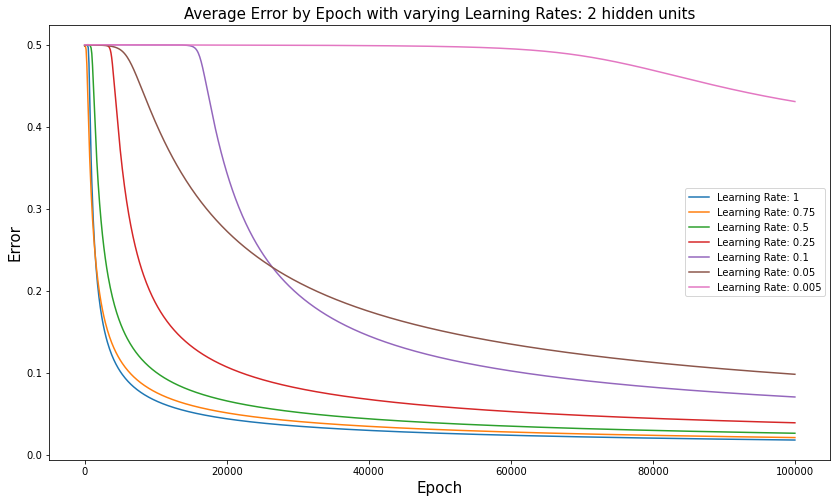



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲2̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.018     |  0.982   |
+----------+---------------+----------+
|   0.75   |     0.021     |  0.979   |
+----------+---------------+----------+
|   0.5    |     0.027     |  0.973   |
+----------+---------------+----------+
|   0.25   |     0.039     |  0.961   |
+----------+---------------+----------+
|   0.1    |     0.071     |  0.929   |
+----------+---------------+----------+
|   0.05   |     0.099     |  0.901   |
+----------+---------------+----------+
|  0.005   |     0.431     |  0.569   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲3
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N

Error after 10000 epochs: 0.5000586627702593
Error after 25000 epochs: 0.4999813040601708
Error after 50000 epochs: 0.49990690869293286
Error after 100000 epochs: 0.49914026217289764

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.49914019761280437 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    | 0.49103380360159027 |
+--------+---------------------+
|   1    | 0.49183451099335507 |
+--------+---------------------+
|   1    |  0.5124517573800975 |
+--------+---------------------+
|   0    |   0.50981325522308  |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲3̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1 

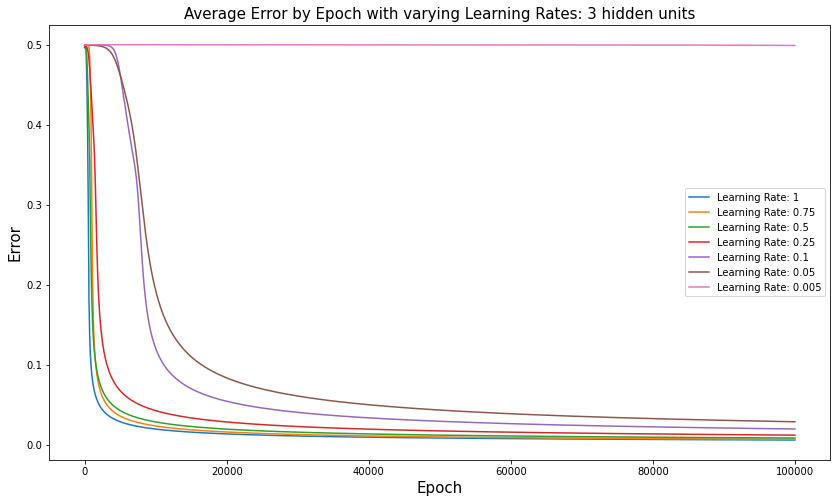



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲3̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.006     |  0.994   |
+----------+---------------+----------+
|   0.75   |     0.007     |  0.993   |
+----------+---------------+----------+
|   0.5    |     0.008     |  0.992   |
+----------+---------------+----------+
|   0.25   |     0.012     |  0.988   |
+----------+---------------+----------+
|   0.1    |      0.02     |   0.98   |
+----------+---------------+----------+
|   0.05   |     0.029     |  0.971   |
+----------+---------------+----------+
|  0.005   |     0.499     |  0.501   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲4
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N

Error after 10000 epochs: 0.5001176063814488
Error after 25000 epochs: 0.49867931973362345
Error after 50000 epochs: 0.47824158073426143
Error after 100000 epochs: 0.32199934848019796

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.32199606340515524 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    | 0.25156989648078276 |
+--------+---------------------+
|   1    |  0.6755156900103068 |
+--------+---------------------+
|   1    |  0.6848843229616136 |
+--------+---------------------+
|   0    |  0.3968143701117586 |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1

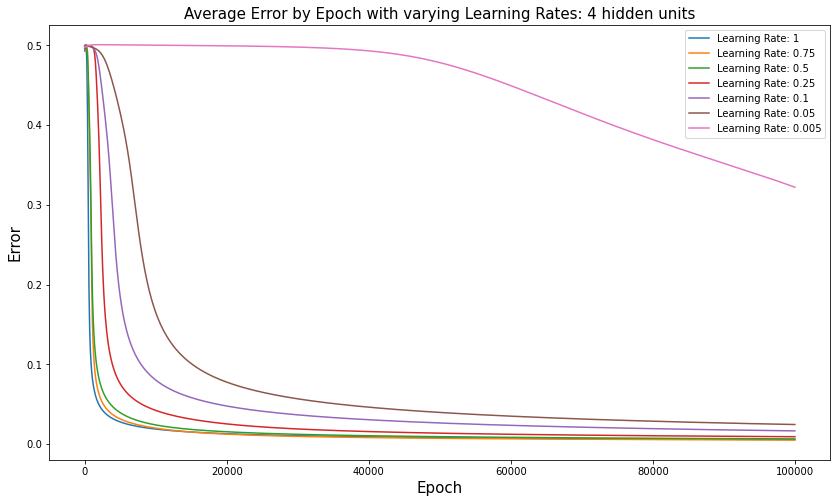



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.006     |  0.994   |
+----------+---------------+----------+
|   0.75   |     0.005     |  0.995   |
+----------+---------------+----------+
|   0.5    |     0.007     |  0.993   |
+----------+---------------+----------+
|   0.25   |     0.009     |  0.991   |
+----------+---------------+----------+
|   0.1    |     0.017     |  0.983   |
+----------+---------------+----------+
|   0.05   |     0.025     |  0.975   |
+----------+---------------+----------+
|  0.005   |     0.322     |  0.678   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲5
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N

Error after 10000 epochs: 0.4979285085428983
Error after 25000 epochs: 0.48682148459044805
Error after 50000 epochs: 0.3961531023623254
Error after 100000 epochs: 0.15383475182093678

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.1538326347353803 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    |  0.1739630924649463 |
+--------+---------------------+
|   1    |  0.8446350020028194 |
+--------+---------------------+
|   1    |  0.8536915815410718 |
+--------+---------------------+
|   0    | 0.13969403002046618 |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲5̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1  

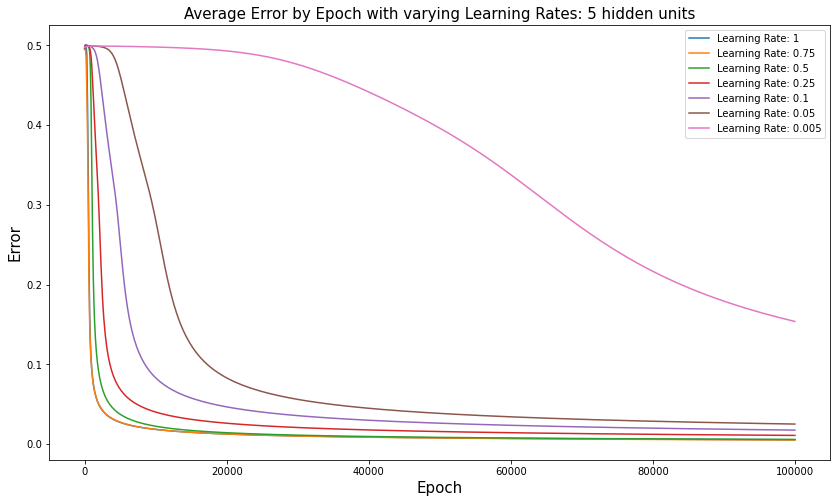



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲5̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.006     |  0.994   |
+----------+---------------+----------+
|   0.75   |     0.005     |  0.995   |
+----------+---------------+----------+
|   0.5    |     0.006     |  0.994   |
+----------+---------------+----------+
|   0.25   |     0.011     |  0.989   |
+----------+---------------+----------+
|   0.1    |     0.018     |  0.982   |
+----------+---------------+----------+
|   0.05   |     0.025     |  0.975   |
+----------+---------------+----------+
|  0.005   |     0.154     |  0.846   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲6
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N

Error after 10000 epochs: 0.4992863051307012
Error after 25000 epochs: 0.4944474899934171
Error after 50000 epochs: 0.42426458459374566
Error after 100000 epochs: 0.158589278008999

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.15858680866388744 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    | 0.16747540377426273 |
+--------+---------------------+
|   1    |  0.8434156872796792 |
+--------+---------------------+
|   1    |  0.8449860194682435 |
+--------+---------------------+
|   0    | 0.15527353762920973 |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲6̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1   

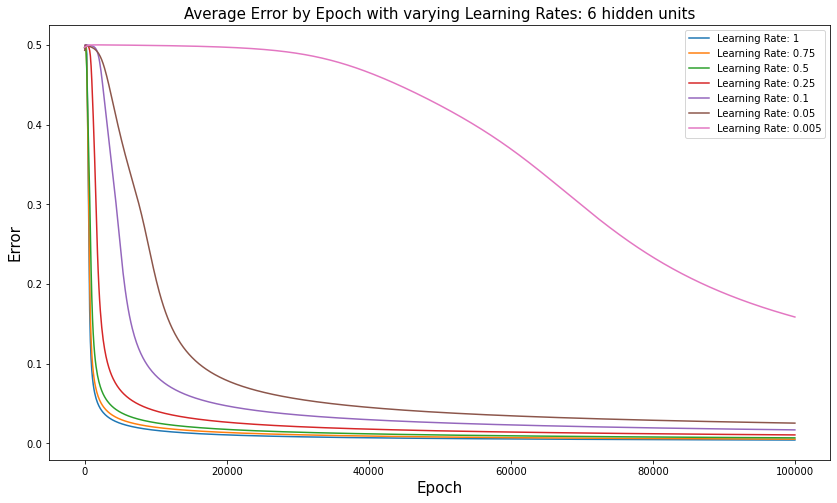



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲6̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.004     |  0.996   |
+----------+---------------+----------+
|   0.75   |     0.005     |  0.995   |
+----------+---------------+----------+
|   0.5    |     0.007     |  0.993   |
+----------+---------------+----------+
|   0.25   |     0.011     |  0.989   |
+----------+---------------+----------+
|   0.1    |     0.017     |  0.983   |
+----------+---------------+----------+
|   0.05   |     0.025     |  0.975   |
+----------+---------------+----------+
|  0.005   |     0.159     |  0.841   |
+----------+---------------+----------+

-----------------------------------------------------------------------------



In [4]:
xor_inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xor_outputs = np.array([[0], [1], [1], [0]])

epochs = 100000
learning_rates = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.005]

num_inputs = 2
num_outputs = 1
hidden_units = [2, 3, 4, 5, 6]

initialise = 'zero_one'

for hidden_unit in hidden_units:
    evaluate_xor(num_inputs, num_outputs, xor_inputs, xor_outputs, epochs, hidden_unit, learning_rates, initialise)

### Testing with Initialisation of Weights Using Xavier Weight Initialisation

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲2
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲1

T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲b̲e̲f̲o̲r̲e̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    | 0.44184369535313583 |
+--------+---------------------+
|   1    | 0.41491271321552214 |
+--------+---------------------+
|   1    |  0.4326464828940271 |
+--------+---------------------+
|   0    | 0.40656246530879975 |
+--------+---------------------+

Error after 100 epochs: 0.5000441395136223
Error after 1000 epochs: 0.4999870638023036
Error after 10000 epochs: 0.31176208439109115
Error after 25000 epochs: 0.2922434560218433
Error after 50000 epochs: 0.2827571579876051
Error after 100000 epochs: 0.27534095858613916

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.27534086235760696 

Error after 10000 epochs: 0.5001870990506725
Error after 25000 epochs: 0.5000890260684464
Error after 50000 epochs: 0.5000339017154005
Error after 100000 epochs: 0.5000050126495076

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.5000050123745529 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    |  0.5002383096936973 |
+--------+---------------------+
|   1    | 0.49900823381684806 |
+--------+---------------------+
|   1    |  0.5006622978350843 |
+--------+---------------------+
|   0    | 0.49945227145644655 |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲2̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-----+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) | 100 |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-----+-------+-------+-------+-------+--------+
|            1          

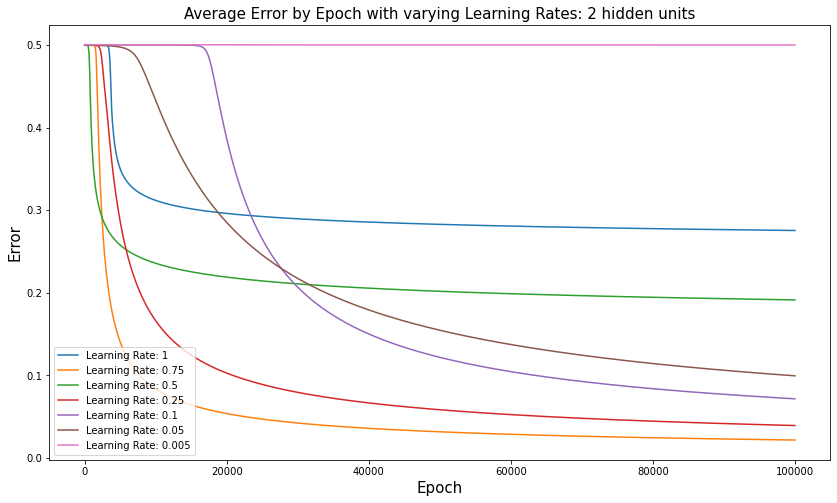



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲2̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.275     |  0.725   |
+----------+---------------+----------+
|   0.75   |     0.022     |  0.978   |
+----------+---------------+----------+
|   0.5    |     0.191     |  0.809   |
+----------+---------------+----------+
|   0.25   |     0.039     |  0.961   |
+----------+---------------+----------+
|   0.1    |     0.072     |  0.928   |
+----------+---------------+----------+
|   0.05   |     0.099     |  0.901   |
+----------+---------------+----------+
|  0.005   |      0.5      |   0.5    |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲3
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
********

Error after 10000 epochs: 0.49999478989769774
Error after 25000 epochs: 0.49996648413172684
Error after 50000 epochs: 0.4999089916273851
Error after 100000 epochs: 0.4985853216363794

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.49858519205480467 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    | 0.48600700607723724 |
+--------+---------------------+
|   1    |  0.5028129050966366 |
+--------+---------------------+
|   1    |  0.5076046568721978 |
+--------+---------------------+
|   0    |  0.5187513241108159 |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲3̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-----+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) | 100 |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-----+-------+-------+-------+-------+--------+
|            1       

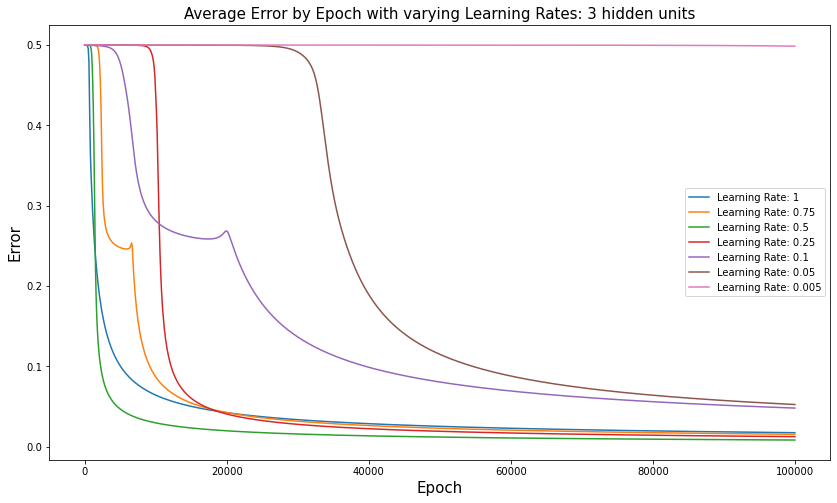



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲3̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.018     |  0.982   |
+----------+---------------+----------+
|   0.75   |     0.015     |  0.985   |
+----------+---------------+----------+
|   0.5    |     0.008     |  0.992   |
+----------+---------------+----------+
|   0.25   |     0.013     |  0.987   |
+----------+---------------+----------+
|   0.1    |     0.048     |  0.952   |
+----------+---------------+----------+
|   0.05   |     0.053     |  0.947   |
+----------+---------------+----------+
|  0.005   |     0.499     |  0.501   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲4
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
********

Error after 10000 epochs: 0.5001191898992544
Error after 25000 epochs: 0.5000069356201202
Error after 50000 epochs: 0.49994312777001615
Error after 100000 epochs: 0.4997787004538362

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.4997786927129883 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    |  0.5032064712204586 |
+--------+---------------------+
|   1    | 0.49144371090993244 |
+--------+---------------------+
|   1    |  0.5109550203038401 |
+--------+---------------------+
|   0    |  0.498307030845267  |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1   

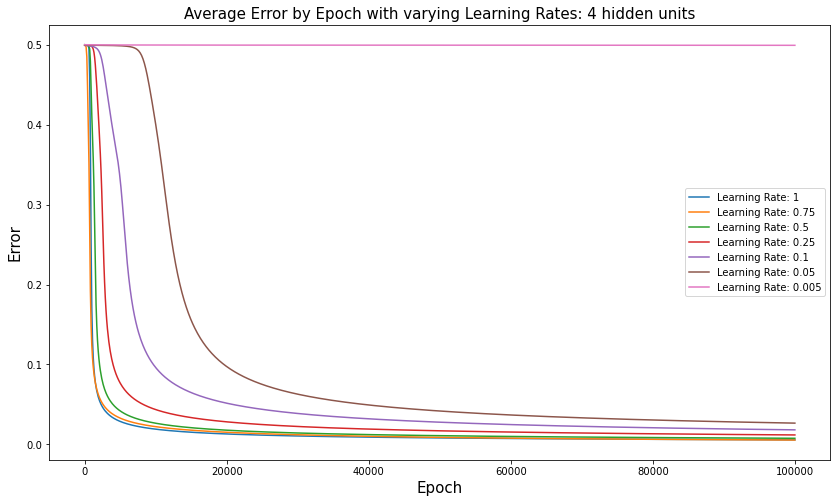



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.006     |  0.994   |
+----------+---------------+----------+
|   0.75   |     0.005     |  0.995   |
+----------+---------------+----------+
|   0.5    |     0.007     |  0.993   |
+----------+---------------+----------+
|   0.25   |     0.012     |  0.988   |
+----------+---------------+----------+
|   0.1    |     0.018     |  0.982   |
+----------+---------------+----------+
|   0.05   |     0.026     |  0.974   |
+----------+---------------+----------+
|  0.005   |      0.5      |   0.5    |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲5
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
********

Error after 10000 epochs: 0.4994443426185706
Error after 25000 epochs: 0.49860898550702865
Error after 50000 epochs: 0.47566304433005674
Error after 100000 epochs: 0.3356997348882057

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.3356972383526333 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    | 0.21746819360295536 |
+--------+---------------------+
|   1    |  0.6648840394012421 |
+--------+---------------------+
|   1    |  0.6534818580690417 |
+--------+---------------------+
|   0    |  0.4436866572778617 |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲5̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1  

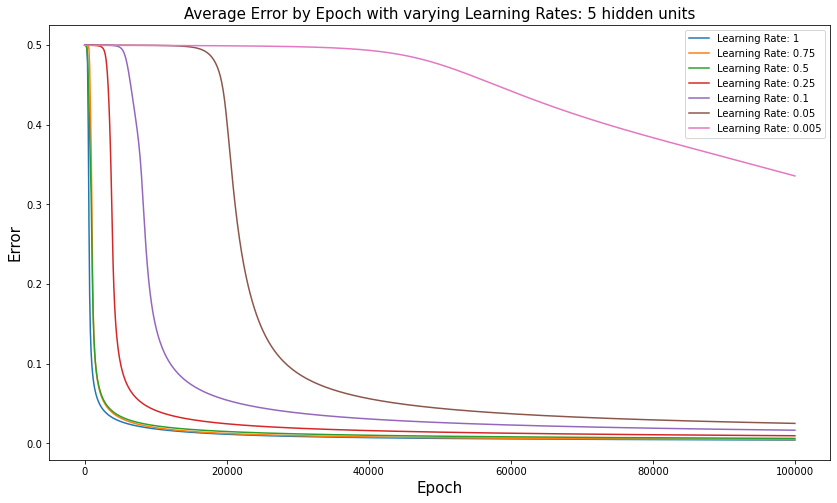



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲5̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.004     |  0.996   |
+----------+---------------+----------+
|   0.75   |     0.005     |  0.995   |
+----------+---------------+----------+
|   0.5    |     0.006     |  0.994   |
+----------+---------------+----------+
|   0.25   |      0.01     |   0.99   |
+----------+---------------+----------+
|   0.1    |     0.017     |  0.983   |
+----------+---------------+----------+
|   0.05   |     0.025     |  0.975   |
+----------+---------------+----------+
|  0.005   |     0.336     |  0.664   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲6
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
********

Error after 10000 epochs: 0.4998208117003978
Error after 25000 epochs: 0.4997201276413189
Error after 50000 epochs: 0.49946669870480775
Error after 100000 epochs: 0.4841595287956769

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.4841571526238302 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+--------------------+
| Target |     Predicted      |
+--------+--------------------+
|   0    | 0.468056289214389  |
+--------+--------------------+
|   1    | 0.5158242216553491 |
+--------+--------------------+
|   1    | 0.5174539895646542 |
+--------+--------------------+
|   0    | 0.501850532500935  |
+--------+--------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲6̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1             |

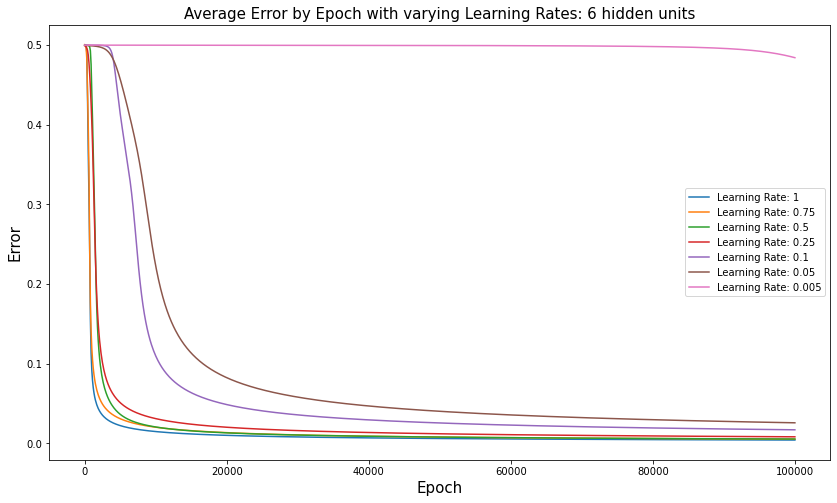



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲6̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.004     |  0.996   |
+----------+---------------+----------+
|   0.75   |     0.005     |  0.995   |
+----------+---------------+----------+
|   0.5    |     0.006     |  0.994   |
+----------+---------------+----------+
|   0.25   |     0.008     |  0.992   |
+----------+---------------+----------+
|   0.1    |     0.017     |  0.983   |
+----------+---------------+----------+
|   0.05   |     0.026     |  0.974   |
+----------+---------------+----------+
|  0.005   |     0.484     |  0.516   |
+----------+---------------+----------+

-----------------------------------------------------------------------------



In [5]:
initialise = 'xavier'
for hidden_unit in hidden_units:
        evaluate_xor(num_inputs, num_outputs, xor_inputs, xor_outputs, epochs, hidden_unit, learning_rates, initialise)

### Testing Method for the XOR Problem With One Input Missing

In this method I initialise the weights between zero and one given that it performed slightly better above.

In [6]:
def evaluate_xor_missing(num_inputs, num_outputs, inputs_missing, outputs_missing, epochs, hidden_units, learning_rates, inputs_full, outputs_full):
    table_units = PrettyTable(["Learning (↓) / Epoch (→)", "100", "1000", "10000", "25000", "50000", "100000"])
    table_units_testing = PrettyTable(["Learning", "Average Error", "Accuracy"])
    
    # plotting
    x_axis = [x for x in range(100, epochs+1, 100)]
    x_axis.insert(0,1)
    y_axis_arrays = []
  
    with open('xor_logs_missing/log_xor_missing_data_point_hidden_' + str(hidden_units) + '_epochs_' + str(epochs)+ '_randomise_' + str(initialise) + '.txt', 'w') as log_file:
        print('****************')
        print("\u0332".join("Hidden Units: " + str(hidden_units)))

        # defaulting to zero_one as found to be better in above tests
        print("\u0332".join("Initialising Weights Randomly Between 0 and 1"))
        log_file.write('Initialising Weights Randomly Between 0 and 1\n')

        log_file.write('Hidden Units: ' + str(hidden_units) + '\n')
        log_file.write('Number of Epochs: ' + str(epochs) + '\n')
        for learning_rate in learning_rates:
            print("\u0332".join("\nLEARNING RATE: " + str(learning_rate)) + "\n")
            log_file.write('\n****************')
            log_file.write('\nLearning Rate: ' + str(learning_rate) + '\n')
            log_file.write('****************\n')
            
            print("\u0332".join("Training log:\n"))
            log_file.write('\nTraining log:\n')
            log_file.write('****************\n')
            NN = MLP(num_inputs, num_outputs, hidden_units)
            NN.randomise(initialise)
            

            print("\u0332".join("Predictions before training"))
            table_training = PrettyTable(["Target", "Predicted"])
            for i in range(len(inputs_missing)):
                NN.forward(inputs_missing[i], 'sigmoid')
                table_training.add_row([str(outputs_missing[i][0]), str(NN.output[0])])
                # add line between each row
                table_training.hrules = 1
            print(table_training)
            print()
            table_row = [str(learning_rate)]
            table_row_testing = [str(learning_rate)]
            plotting_array = []
  
            for i in range(1, epochs+1):
                error = 0
                NN.forward(inputs_missing, 'sigmoid')
                error += NN.backwards(outputs_missing, inputs_missing, 'sigmoid')
                NN.update_weights(learning_rate)
                # periodically display error rate
                if i == 100 or i==1000 or i==10000 or i==25000 or i %50000 == 0:
                    table_row.append(str(round(error, 3)))
                    print("Error after", str(i), "epochs:", str(error))
                    log_file.write("Error after " + str(i) + " epochs: " + str(error)+ '\n')
                if i % 100 == 0 or i==1:
                    plotting_array.append(error)
            y_axis_arrays.append(plotting_array)
                    
            table_units.add_row(table_row)
            # add line between each row
            table_units.hrules = 1
            print("\u0332".join("\nTesting log:\n"))
            log_file.write('\nTesting log:\n')
            log_file.write('****************')
            testing_predictions = []
            differences = 0
    
            table_testing = PrettyTable(["Target", "Predicted"])
            for i in range(len(inputs_full)):
                NN.forward(inputs_full[i], 'sigmoid')
                table_testing.add_row([str(outputs_full[i][0]), str(NN.output[0])])
                log_file.write('\nTarget: ' + str(outputs_full[i][0]) + '\n')
                log_file.write('Prediction: ' + str(NN.output[0]) + '\n')
                # add line between each row
                table_testing.hrules = 1
                testing_predictions.append([NN.output[0]])
                differences += abs(NN.output[0] - outputs_full[i][0])
            
            accuracy = 1 -(differences/len(inputs_full))
            testing_error = np.subtract(testing_predictions, outputs_full)
            testing_ave_error = np.mean(np.abs(testing_error))
            table_row_testing.append(str(round(testing_ave_error, 3)))
            table_row_testing.append(str(round(accuracy, 3)))
            table_units_testing.add_row(table_row_testing)
            # add line between each row
            table_units_testing.hrules = 1
            print("Average Error on Test Set:", testing_ave_error, "\n")
            log_file.write('\nAverage Error on Test Set: ' + str(testing_ave_error) + '\n')
            print("\u0332".join("Predictions after training"))
            print(table_testing)
        log_file.write('\n-----------------------------------------------------------------------------\n')
    
    print("\u0332".join("\nTraining Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units)
                                     
    print()
    plt.figure(figsize=(14,8))
    for i in range(len(learning_rates)):

        plt.plot(x_axis, y_axis_arrays[i], label="Learning Rate: {:s}".format(str(learning_rates[i])))
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Error", fontsize=15)
    plt.title("Average Error by Epoch with varying Learning Rates: {:s} hidden units".format(str(hidden_units)), fontsize=15)
    plt.legend()
    plt.show()
    print()
    print("\u0332".join("\nTesting Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units_testing)
        
    print('\n-----------------------------------------------------------------------------\n')

### Testing XOR problem after dropping one Training Data Point

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲2
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲1

T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲b̲e̲f̲o̲r̲e̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+--------------------+
| Target |     Predicted      |
+--------+--------------------+
|   0    | 0.4216369249184795 |
+--------+--------------------+
|   1    | 0.4171809351432854 |
+--------+--------------------+
|   1    | 0.4462716490624859 |
+--------+--------------------+

Error after 100 epochs: 0.41316471384934655
Error after 1000 epochs: 0.0529136676340522
Error after 10000 epochs: 0.013072078305306338
Error after 25000 epochs: 0.008094104749734389
Error after 50000 epochs: 0.00567201925206709
Error after 100000 epochs: 0.003987696221319223

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.2523985250114016 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+----------------------+
| 

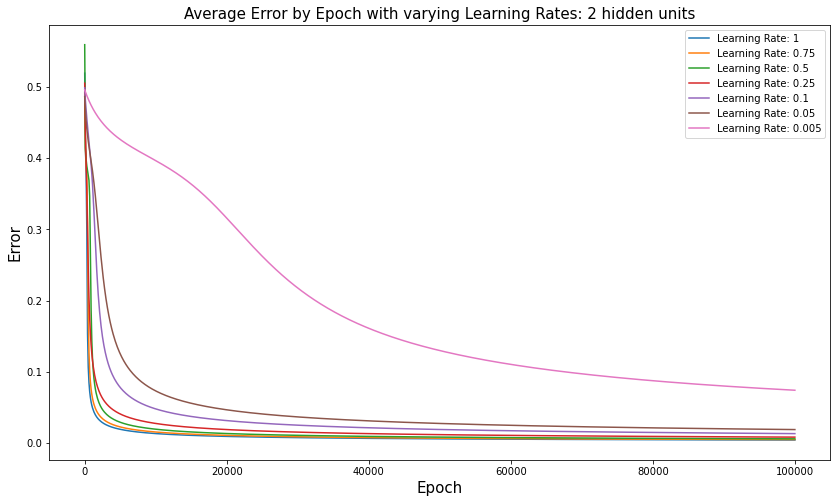



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲2̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.75   |     0.253     |  0.747   |
+----------+---------------+----------+
|   0.5    |     0.253     |  0.747   |
+----------+---------------+----------+
|   0.25   |     0.255     |  0.745   |
+----------+---------------+----------+
|   0.1    |     0.258     |  0.742   |
+----------+---------------+----------+
|   0.05   |     0.262     |  0.738   |
+----------+---------------+----------+
|  0.005   |     0.297     |  0.703   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲3
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N

Error after 10000 epochs: 0.4215757040868926
Error after 25000 epochs: 0.4005097106917215
Error after 50000 epochs: 0.3370036932512228
Error after 100000 epochs: 0.0994648185813241

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.3136600076217967 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+--------------------+
| Target |     Predicted      |
+--------+--------------------+
|   0    | 0.1426415863193767 |
+--------+--------------------+
|   1    | 0.921837716148014  |
+--------+--------------------+
|   1    | 0.9224130667906758 |
+--------+--------------------+
|   0    | 0.9562492271064998 |
+--------+--------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲3̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1             | 

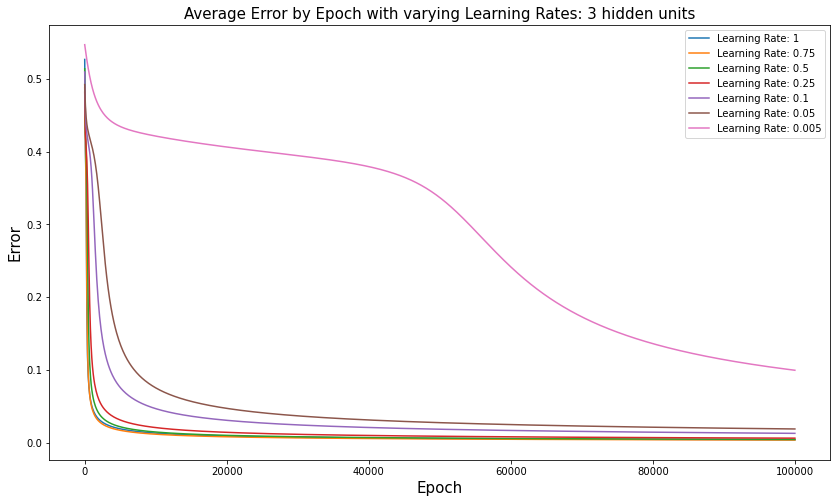



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲3̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.75   |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.5    |     0.253     |  0.747   |
+----------+---------------+----------+
|   0.25   |     0.254     |  0.746   |
+----------+---------------+----------+
|   0.1    |     0.258     |  0.742   |
+----------+---------------+----------+
|   0.05   |     0.262     |  0.738   |
+----------+---------------+----------+
|  0.005   |     0.314     |  0.686   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲4
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N

Error after 10000 epochs: 0.4116856953592813
Error after 25000 epochs: 0.2773743255338979
Error after 50000 epochs: 0.12905600777032103
Error after 100000 epochs: 0.07001536155059894

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.2943729256627689 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+--------------------+
| Target |     Predicted      |
+--------+--------------------+
|   0    | 0.0939340315782324 |
+--------+--------------------+
|   1    | 0.9427427493546018 |
+--------+--------------------+
|   1    | 0.9411468544951741 |
+--------+--------------------+
|   0    | 0.9674472749226192 |
+--------+--------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1             

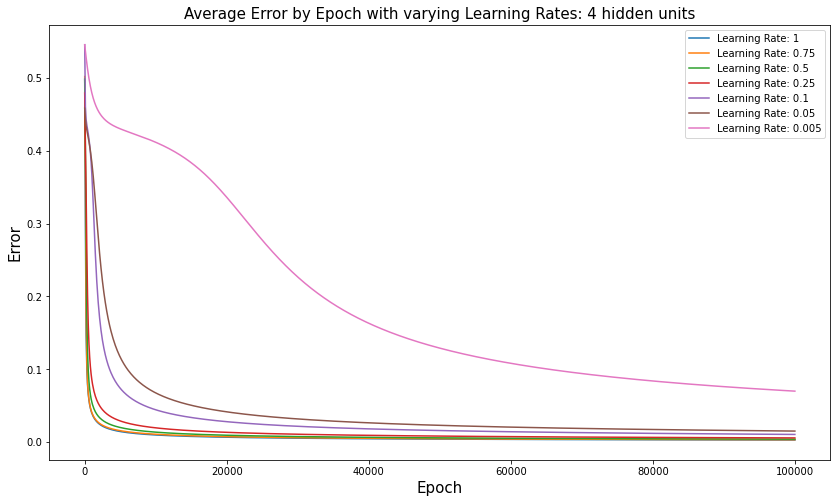



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.75   |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.5    |     0.253     |  0.747   |
+----------+---------------+----------+
|   0.25   |     0.254     |  0.746   |
+----------+---------------+----------+
|   0.1    |     0.257     |  0.743   |
+----------+---------------+----------+
|   0.05   |      0.26     |   0.74   |
+----------+---------------+----------+
|  0.005   |     0.294     |  0.706   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲5
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N

Error after 10000 epochs: 0.3600899029829329
Error after 25000 epochs: 0.17081840015474228
Error after 50000 epochs: 0.08538447966253045
Error after 100000 epochs: 0.04947101465386935

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.28430017835625443 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    | 0.06398752379430336 |
+--------+---------------------+
|   1    |  0.9580425982285306 |
+--------+---------------------+
|   1    |  0.9575329381676547 |
+--------+---------------------+
|   0    |  0.9887887260268997 |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲5̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1

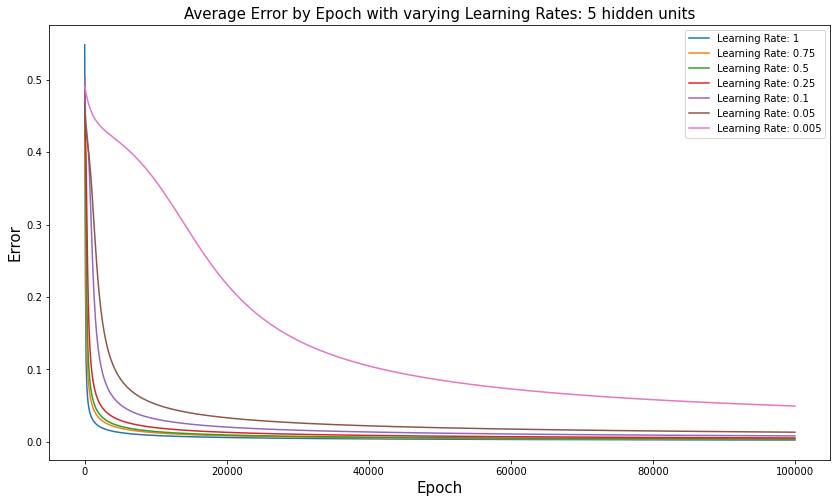



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲5̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.75   |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.5    |     0.253     |  0.747   |
+----------+---------------+----------+
|   0.25   |     0.254     |  0.746   |
+----------+---------------+----------+
|   0.1    |     0.256     |  0.744   |
+----------+---------------+----------+
|   0.05   |     0.259     |  0.741   |
+----------+---------------+----------+
|  0.005   |     0.284     |  0.716   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲6
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N

Error after 10000 epochs: 0.35581129101451175
Error after 25000 epochs: 0.1674785264105492
Error after 50000 epochs: 0.08700118702189302
Error after 100000 epochs: 0.0517260301304299

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.2862353254366381 

P̲r̲e̲d̲i̲c̲t̲i̲o̲n̲s̲ ̲a̲f̲t̲e̲r̲ ̲t̲r̲a̲i̲n̲i̲n̲g
+--------+---------------------+
| Target |      Predicted      |
+--------+---------------------+
|   0    | 0.07137680350319722 |
+--------+---------------------+
|   1    |  0.9576499915842588 |
+--------+---------------------+
|   1    |  0.9585497831715599 |
+--------+---------------------+
|   0    |  0.9897642729991739 |
+--------+---------------------+

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲6̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|            1  

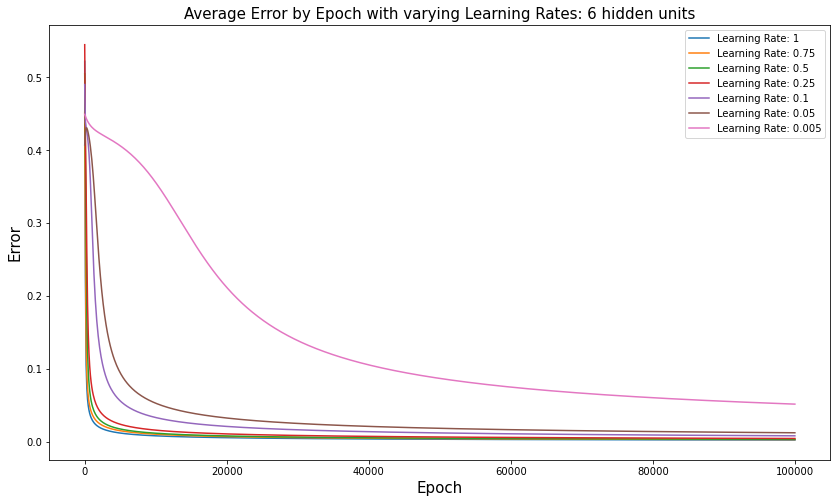



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲6̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|    1     |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.75   |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.5    |     0.252     |  0.748   |
+----------+---------------+----------+
|   0.25   |     0.253     |  0.747   |
+----------+---------------+----------+
|   0.1    |     0.256     |  0.744   |
+----------+---------------+----------+
|   0.05   |     0.259     |  0.741   |
+----------+---------------+----------+
|  0.005   |     0.286     |  0.714   |
+----------+---------------+----------+

-----------------------------------------------------------------------------



In [7]:
xor_inputs_full = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xor_outputs_full = np.array([[0], [1], [1], [0]])

xor_inputs_missing = np.array([[0, 0], [0, 1], [1, 0]])
xor_outputs_missing = np.array([[0], [1], [1]])

epochs = 100000
learning_rates = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.005]

num_inputs = 2
num_outputs = 1
hidden_units = [2, 3, 4, 5, 6]

for hidden_unit in hidden_units:
    evaluate_xor_missing(num_inputs, num_outputs, xor_inputs_missing, xor_outputs_missing, epochs, hidden_unit, learning_rates, xor_inputs_full, xor_outputs_full)

# Sin

### Testing Method for the Sin Problem

In [8]:
def evaluate_sin(num_inputs, num_outputs, inputs, outputs, testing, testing_outputs, epochs, hidden_units, learning_rates, initialise):
    table_units = PrettyTable(["Learning (↓) / Epoch (→)", "100", "1000", "10000", "25000", "50000", "100000"])
    table_units_testing = PrettyTable(["Learning", "Average Error", "Accuracy"])
    
    # plotting
    x_axis = [x for x in range(100, epochs+1, 100)]
    x_axis.insert(0,1)
    y_axis_arrays = []
    
    with open('sin_logs/log_sin_hidden_' + str(hidden_units) + '_epochs_' + str(epochs) + '_randomise_' + str(initialise)+ '.txt', 'w') as log_file:
        print('****************')
        print("\u0332".join("Hidden Units: " + str(hidden_units)))
        if initialise == 'zero_one':
            print("\u0332".join("Initialising Weights Randomly Between 0 and 1"))
            log_file.write('Initialising Weights Randomly Between 0 and 1\n')
        else:
            print("\u0332".join("Initialising Weights Using Xavier Weight Initialisation"))
            log_file.write('Initialising Weights Using Xavier Weight Initialisation\n')
        print('****************')
        log_file.write('Hidden Units: ' + str(hidden_units) + '\n')
        log_file.write('Number of Epochs: ' + str(epochs) + '\n')
        for learning_rate in learning_rates:
            plotting_array = []
            
            table_row = [str(learning_rate)]
            table_row_testing = [str(learning_rate)]
            mlp = MLP(num_inputs, num_outputs, hidden_units)
            mlp.randomise(initialise)
            
            print("\u0332".join("\nLEARNING RATE: " + str(learning_rate)))
            log_file.write('\n****************')
            log_file.write('\nLearning Rate: ' + str(learning_rate) + '\n')
            log_file.write('****************\n')

            print("\u0332".join("Training log: \n"))
            log_file.write('\nTraining log:\n')
            log_file.write('****************\n')
            for i in range(1, epochs+1):
                error = 0
                mlp.forward(inputs, 'tanh')
                error += mlp.backwards(outputs, np.array(inputs), 'tanh')
                mlp.update_weights(learning_rate)
                # periodically display error rate
                if i == 100 or i==1000 or i==10000 or i==25000 or i %50000 == 0:
                    table_row.append(str(round(error, 3)))
                    print("Error after", str(i), "epochs:", str(error))
                    log_file.write("Error after " + str(i) + " epochs: " + str(error)+ '\n')

                    
                if i % 100 == 0 or i==1:
                    plotting_array.append(error)
            y_axis_arrays.append(plotting_array)
            
            table_units.add_row(table_row)
            # add line between each row
            table_units.hrules = 1
            print("\u0332".join("\nTesting log:\n"))
            log_file.write('\nTesting log (showing every fourth set of targets/predictions):\n')
            log_file.write('****************')
            testing_predictions = []
            differences = 0
            for i in range(len(testing)):
                mlp.forward(testing[i], 'tanh')
                testing_predictions.append([mlp.output[0]])
                if i % 4 == 0:
                    log_file.write('\nTarget: ' + str(testing[i][0]) + '\n')
                    log_file.write('Prediction: ' + str(mlp.output[0]) + '\n')
                differences += abs(mlp.output[0] - testing_outputs[i][0])
            accuracy = 1 -(differences/len(testing))
            testing_error = np.subtract(testing_predictions, testing_outputs)
            testing_ave_error = np.mean(np.abs(testing_error))
            table_row_testing.append(str(round(testing_ave_error, 3)))
            table_row_testing.append(str(round(accuracy, 3)))
            table_units_testing.add_row(table_row_testing)
            # add line between each row
            table_units_testing.hrules = 1
            log_file.write('\nAverage Error on Test Set: ' + str(testing_ave_error) + '\n')
            print("Average Error on Test Set:", testing_ave_error)
        log_file.write('\n-----------------------------------------------------------------------------\n')
    
    print("\u0332".join("\nTraining Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units)
                                     
    print()
    plt.figure(figsize=(14,8))
    for i in range(len(learning_rates)):

        plt.plot(x_axis, y_axis_arrays[i], label="Learning Rate: {:s}".format(str(learning_rates[i])))
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Error", fontsize=15)
    plt.title("Average Error by Epoch with varying Learning Rates: {:s} hidden units".format(str(hidden_units)), fontsize=15)
    plt.legend()
    plt.show()
    print()
    print("\u0332".join("\nTesting Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units_testing)
    
    print('\n-----------------------------------------------------------------------------\n')

### Initialising Inputs and Testing with Initialisation of Weights Between Zero and One

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲5
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.3833877814192168
Error after 1000 epochs: 0.41529210574260433
Error after 10000 epochs: 0.35936296244321364
Error after 25000 epochs: 0.38848126450448134
Error after 50000 epochs: 0.3884812645043684
Error after 100000 epochs: 0.3884812645041354

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.3582789483877544

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲0̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.07273832906588776
Error after 1000 epochs: 0.10606028878742958
Error after 10000 epochs: 0.10430313199319645
Error after 25000 epochs: 0.1157837611970833
Error after 50000 epochs: 0.10352245267490573
Error after 100000 epochs: 0.10749031388908825

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.11613287142552747

̲L̲E̲A̲R̲N̲I̲N

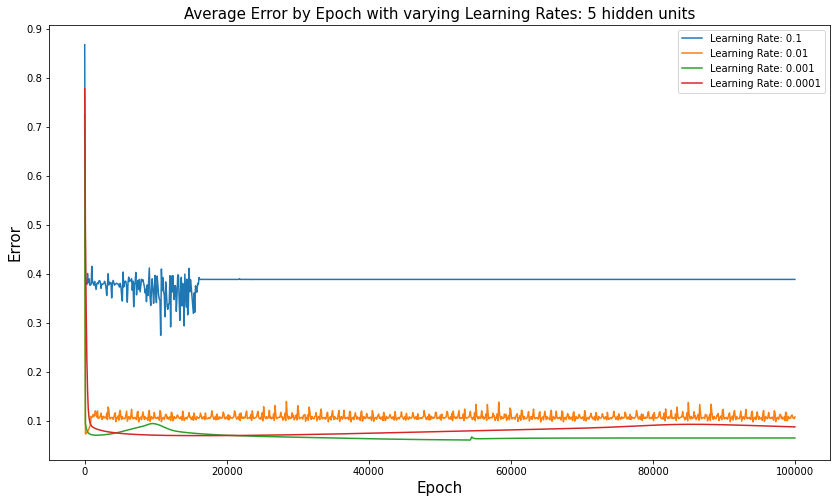



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲5̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |     0.358     |  0.642   |
+----------+---------------+----------+
|   0.01   |     0.116     |  0.884   |
+----------+---------------+----------+
|  0.001   |      0.07     |   0.93   |
+----------+---------------+----------+
|  0.0001  |     0.091     |  0.909   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲8
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.35789164755243363
Error after 1000 epochs: 0.3669258457092201
Error after 10000 epochs: 0.3846066220123785
Error after 25000 epochs: 0.3516108184985336
Error

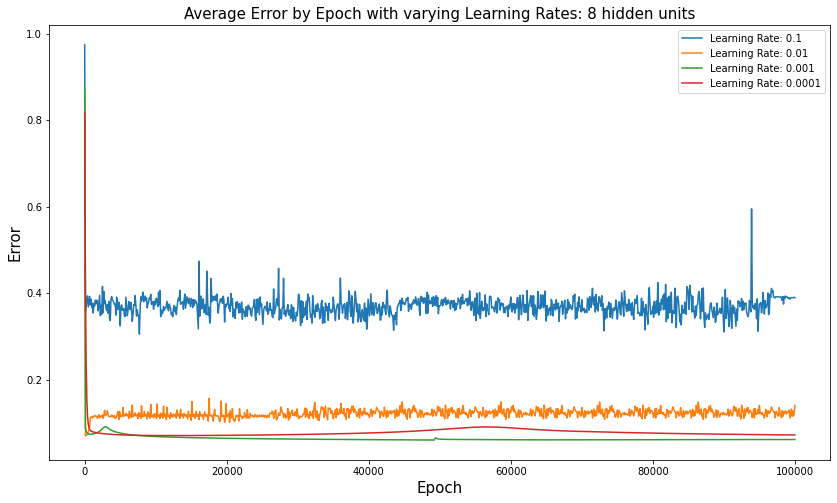



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲8̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |     0.356     |  0.644   |
+----------+---------------+----------+
|   0.01   |     0.151     |  0.849   |
+----------+---------------+----------+
|  0.001   |     0.066     |  0.934   |
+----------+---------------+----------+
|  0.0001  |     0.077     |  0.923   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲1̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.39476988436762567
Error after 1000 epochs: 0.3889227185952556
Error after 10000 epochs: 0.37184761216630074
Error after 25000 epochs: 0.36362321027940275
E

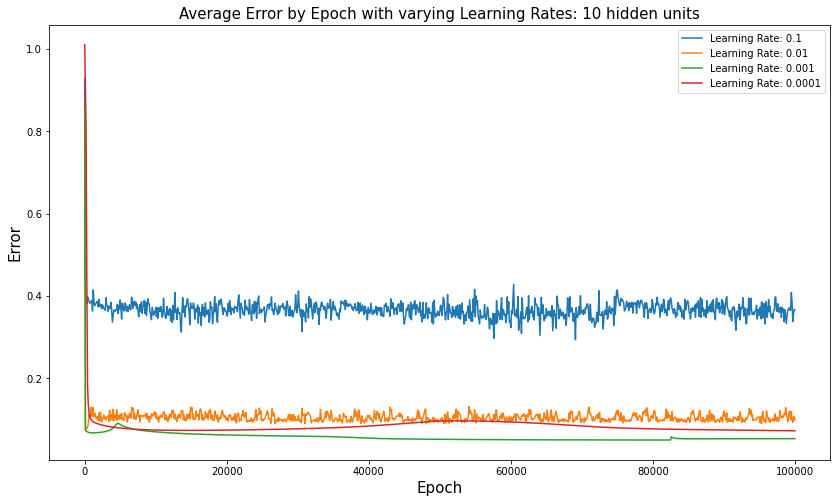



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲1̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |     0.351     |  0.649   |
+----------+---------------+----------+
|   0.01   |     0.107     |  0.893   |
+----------+---------------+----------+
|  0.001   |      0.06     |   0.94   |
+----------+---------------+----------+
|  0.0001  |     0.072     |  0.928   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲2̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.3712355529648012
Error after 1000 epochs: 0.39512429360425705
Error after 10000 epochs: 0.3890323903856877
Error after 25000 epochs: 0.36423377250802885


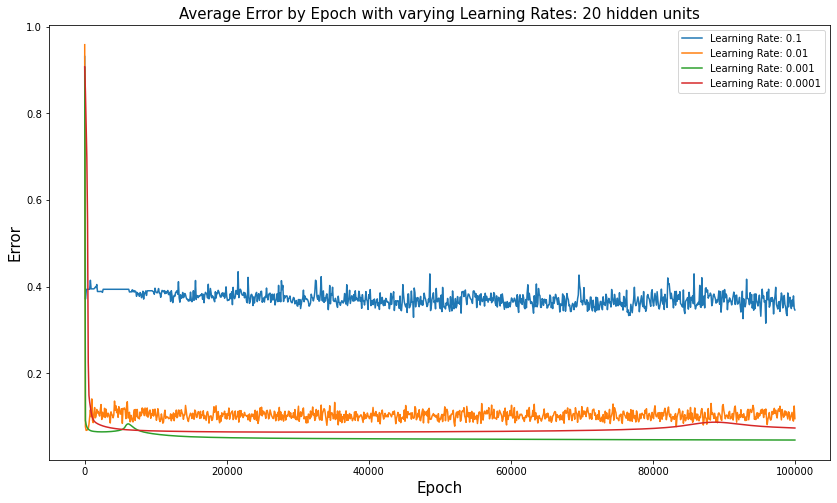



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲2̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |     0.306     |  0.694   |
+----------+---------------+----------+
|   0.01   |     0.096     |  0.904   |
+----------+---------------+----------+
|  0.001   |     0.058     |  0.942   |
+----------+---------------+----------+
|  0.0001  |     0.075     |  0.925   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲4̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.3806124864165647
Error after 1000 epochs: 0.3909062489465625
Error after 10000 epochs: 0.392420598585245
Error after 25000 epochs: 0.39242059806313706
Er

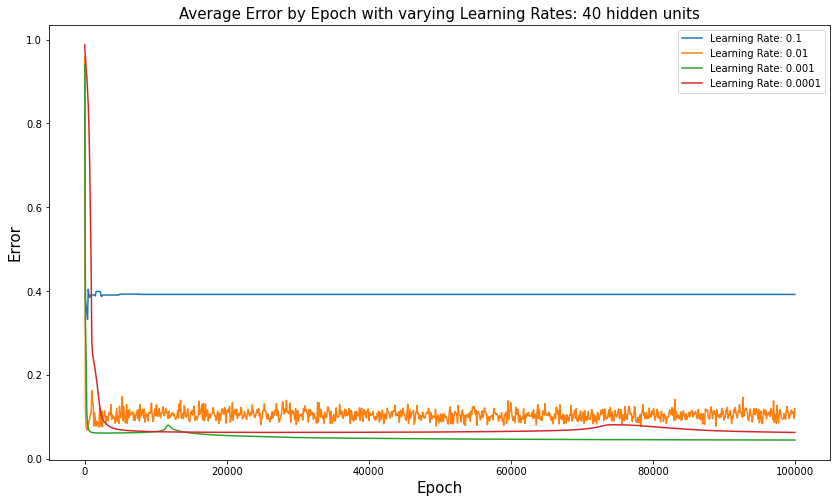



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |      0.36     |   0.64   |
+----------+---------------+----------+
|   0.01   |     0.119     |  0.881   |
+----------+---------------+----------+
|  0.001   |     0.056     |  0.944   |
+----------+---------------+----------+
|  0.0001  |     0.069     |  0.931   |
+----------+---------------+----------+

-----------------------------------------------------------------------------



In [9]:
# 500 vectors with 4 digits randomly assigned between -1 and 1
vectors = [np.random.uniform(low=-1, high=1, size = 4) for x in range(500)]
# set training to be first 400 and testing last 100
training = vectors[:400]
testing = vectors[400:]
outputs = []
for vector in vectors:
    sum_vector = vector[0] - vector[1] + vector[2] - vector[3]
    sined = np.sin(sum_vector)
    outputs.append([sined])
outputs = np.array(outputs)
output_training = outputs[:400]
output_testing = outputs[400:]

epochs = 100000
learning_rates = [0.1, 0.01, 0.001, 0.0001]

num_inputs = 4
num_outputs = 1
hidden_units = [5, 8, 10, 20, 40]
initialise = 'zero_one'

for hidden_unit in hidden_units:
    evaluate_sin(num_inputs, num_outputs, training, output_training, testing, output_testing, epochs, hidden_unit, learning_rates, initialise)

### Testing with Initialisation of Weights Using Xavier Weight Initialisation

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲5
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.35021706765450866
Error after 1000 epochs: 0.3763903401911832
Error after 10000 epochs: 0.364564401272663
Error after 25000 epochs: 0.3718040644131734
Error after 50000 epochs: 0.39181821686812285
Error after 100000 epochs: 0.39322865628947257

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.3566953552340471

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲0̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.06807437197364594
Error after 1000 epochs: 0.09021496702725659
Error after 10000 epochs: 0.10678763616789619
Error after 25000 epochs: 0.10672426154889854
Error after 50000 epochs: 0.10644325664600073
Error after 100000 epochs: 0.10631170487584654

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Average Error on Test Set: 0.1047676505784

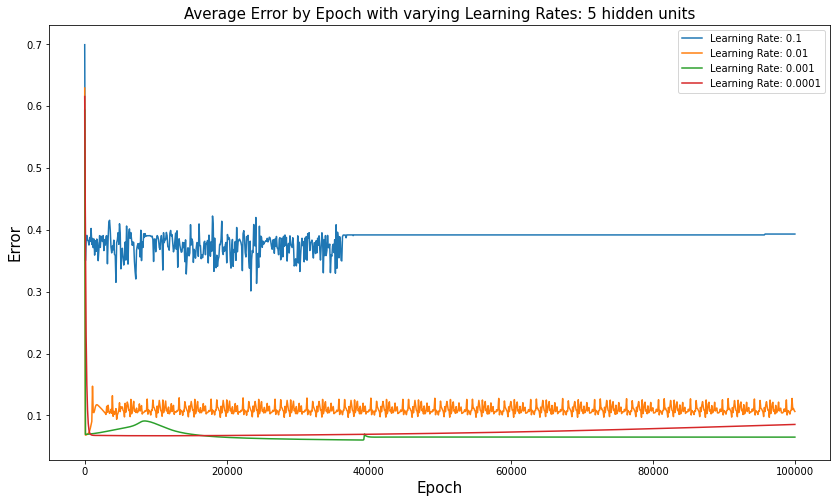



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲5̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |     0.357     |  0.643   |
+----------+---------------+----------+
|   0.01   |     0.105     |  0.895   |
+----------+---------------+----------+
|  0.001   |     0.068     |  0.932   |
+----------+---------------+----------+
|  0.0001  |     0.074     |  0.926   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲8
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.35877319225271653
Error after 1000 epochs: 0.3431640659540801
Error after 10000 epochs: 0.34299948245913725
Error after 25000 epochs: 0.3

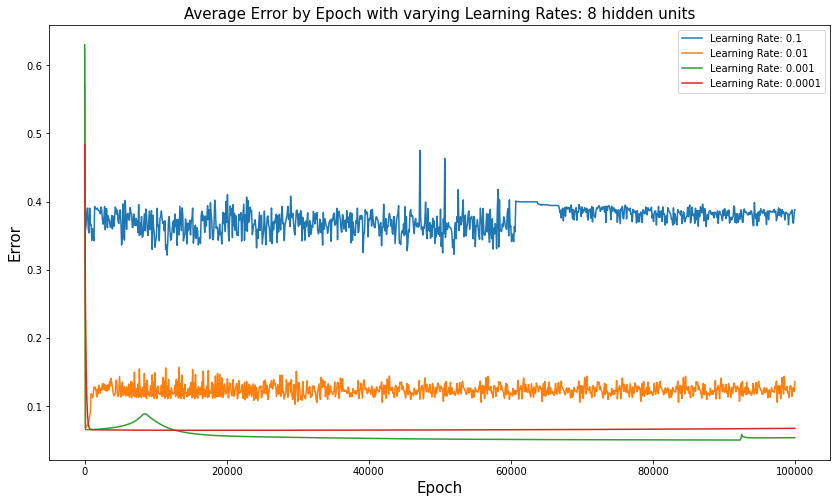



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲8̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |     0.366     |  0.634   |
+----------+---------------+----------+
|   0.01   |     0.146     |  0.854   |
+----------+---------------+----------+
|  0.001   |      0.06     |   0.94   |
+----------+---------------+----------+
|  0.0001  |     0.057     |  0.943   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲1̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.37394500870751785
Error after 1000 epochs: 0.38742932679720243
Error after 10000 epochs: 0.3555306973790256
Error after 25000 epochs: 0

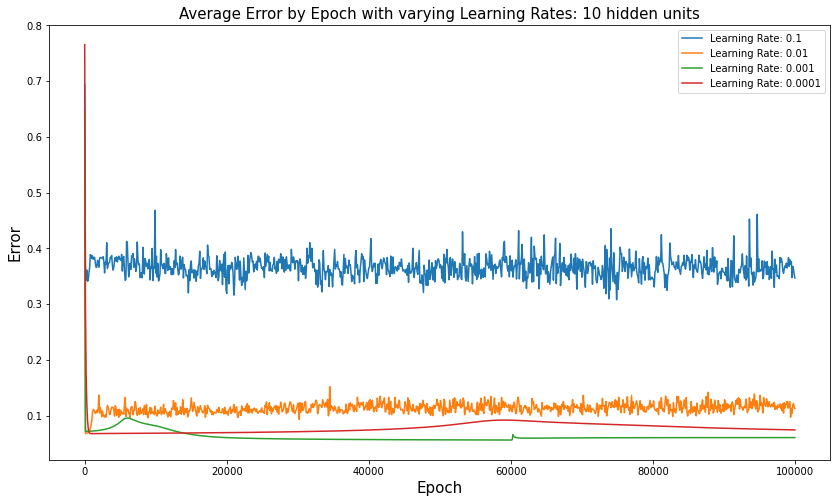



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲1̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |     0.358     |  0.642   |
+----------+---------------+----------+
|   0.01   |     0.113     |  0.887   |
+----------+---------------+----------+
|  0.001   |     0.066     |  0.934   |
+----------+---------------+----------+
|  0.0001  |     0.083     |  0.917   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲2̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.3814496952678292
Error after 1000 epochs: 0.3626226149855193
Error after 10000 epochs: 0.38967110114327097
Error after 25000 epochs: 

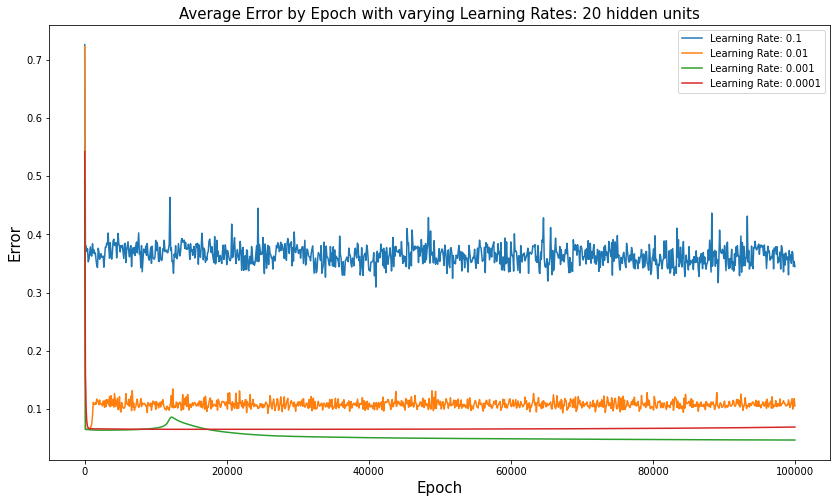



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲2̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |     0.306     |  0.694   |
+----------+---------------+----------+
|   0.01   |     0.103     |  0.897   |
+----------+---------------+----------+
|  0.001   |     0.058     |  0.942   |
+----------+---------------+----------+
|  0.0001  |     0.058     |  0.942   |
+----------+---------------+----------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲4̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲ ̲

Error after 100 epochs: 0.3863595583800962
Error after 1000 epochs: 0.38764806714693323
Error after 10000 epochs: 0.39264410557920504
Error after 25000 epochs:

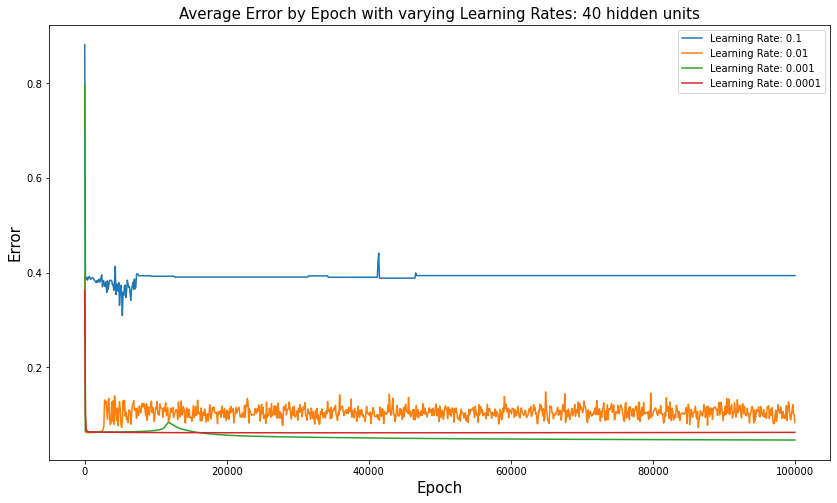



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+----------+
| Learning | Average Error | Accuracy |
+----------+---------------+----------+
|   0.1    |     0.359     |  0.641   |
+----------+---------------+----------+
|   0.01   |     0.091     |  0.909   |
+----------+---------------+----------+
|  0.001   |     0.057     |  0.943   |
+----------+---------------+----------+
|  0.0001  |     0.053     |  0.947   |
+----------+---------------+----------+

-----------------------------------------------------------------------------



In [10]:
initialise = 'xavier'
for hidden_unit in hidden_units:
        evaluate_sin(num_inputs, num_outputs, training, output_training, testing, output_testing, epochs, hidden_unit, learning_rates, initialise)

# Letter Recognition

### Testing Method for the Letter Recognition Problem

In [25]:
def evaluate_letter_recognition(num_inputs, num_outputs, inputs, outputs, testing, testing_outputs, epochs, hidden_units, learning_rates, actual_test_vals, initialise):
    def convert_to_char(np_arr):
        list_arr = list(np_arr)
        index = list_arr.index(max(list_arr))
        # convert to a character based on the index of the highest value in the list
        return chr(index+ord('A'))
    
#     table_units = PrettyTable(["Learning (↓) / Epoch (→)", "100", "1000", "10000", "25000", "50000", "100000"])
    table_units = PrettyTable(["Learning (↓) / Epoch (→)", "100", "500", "1000", "2000", "5000", "10000"])
    table_units_testing = PrettyTable(["Learning", "Average Error", "Correct Predictions"])
    
    # plotting
    x_axis = [x for x in range(100, epochs+1, 100)]
    x_axis.insert(0,1)
    y_axis_arrays = []
    
    with open('image_logs/log_letter_recognition_hidden_' + str(hidden_units) + '_epochs_' + str(epochs) + '_randomise_' + str(initialise)+ '.txt', 'w') as log_file:
        print('****************')
        print("\u0332".join("Hidden Units: " + str(hidden_units)))
        if initialise == 'zero_one':
            print("\u0332".join("Initialising Weights Randomly Between 0 and 1"))
            log_file.write('Initialising Weights Randomly Between 0 and 1\n')
        else:
            print("\u0332".join("Initialising Weights Using Xavier Weight Initialisation"))
            log_file.write('Initialising Weights Using Xavier Weight Initialisation\n')
        print('****************')
        
        log_file.write('Hidden Units: ' + str(hidden_units) + '\n')
        log_file.write('Number of Epochs: ' + str(epochs) + '\n')
        for learning_rate in learning_rates:
            plotting_array = []
            
            table_row = [str(learning_rate)]
            table_row_testing = [str(learning_rate)]
            mlp = MLP(num_inputs, num_outputs, hidden_units)
            mlp.randomise(initialise)
            
            print("\u0332".join("\nLEARNING RATE: " + str(learning_rate)))
            log_file.write('\n****************')
            log_file.write('\nLearning Rate: ' + str(learning_rate) + '\n')
            log_file.write('****************\n')

            print("\u0332".join("Training log:\n"))
            log_file.write('\nTraining log:\n')
            log_file.write('****************\n')

            for i in range(1, epochs+1):
                error = 0
                mlp.forward(np.array(inputs), 'tanh')
                error += mlp.backwards(np.array(outputs), np.array(inputs), 'tanh')
                mlp.update_weights(learning_rate)
                # periodically display error rate
                if i == 100 or i==500 or i==1000 or i==2000 or i==5000 or i==10000:
                    table_row.append(str(round(error, 3)))
                    print("Error after", str(i), "epochs:", str(error))
                    log_file.write("Error after " + str(i) + " epochs: " + str(error)+ '\n')
                
                if i % 100 == 0 or i==1:
                    plotting_array.append(error)
            y_axis_arrays.append(plotting_array)

            table_units.add_row(table_row)
            # add line between each row
            table_units.hrules = 1
            print("\u0332".join("\nTesting log:\n"))
            log_file.write('\nTesting log (showing every tenth set of targets/predictions):\n')
            log_file.write('****************')
            testing_predictions = []
            correct_predictions = 0
            for i in range(len(testing)):
                mlp.forward(testing[i], 'tanh')
                char_pred = convert_to_char(mlp.output)
                testing_predictions.append([mlp.output[0]])
                if i % 10 == 0:
                    log_file.write('\nTarget: ' + actual_test_vals[i] + '\n')
                    log_file.write('Prediction: ' + str(char_pred) + '\n')
                if str(char_pred) == actual_test_vals[i]:
                    correct_predictions += 1
                
            testing_error = np.subtract(testing_predictions, testing_outputs)
            testing_ave_error = np.mean(np.abs(testing_error))
            table_row_testing.append(str(round(testing_ave_error, 3)))
            
            correct_predictions = round(correct_predictions/len(testing)*100,2)
            print("Correct Predictions: " + str(correct_predictions)+"%")
            table_row_testing.append(str(correct_predictions)+"%")
            table_units_testing.add_row(table_row_testing)
            # add line between each row
            table_units_testing.hrules = 1
            log_file.write('\nAverage Error on Test Set: ' + str(testing_ave_error) + '\n')
            print("Average Error on Test Set:", testing_ave_error)
            log_file.write('\nCorrectly Predicted: ' + str(correct_predictions) + '% of test set\n')
        log_file.write('\n-----------------------------------------------------------------------------\n')
        
    print("\u0332".join("\nTraining Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units)
    
    print()
    plt.figure(figsize=(14,8))
    for i in range(len(learning_rates)):

        plt.plot(x_axis, y_axis_arrays[i], label="Learning Rate: {:s}".format(str(learning_rates[i])))
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Error", fontsize=15)
    plt.title("Average Error by Epoch with varying Learning Rates: {:s} hidden units".format(str(hidden_units)), fontsize=15)
    plt.legend()
    plt.show()
    print()
    
    print("\u0332".join("\nTesting Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units_testing)
    
    print('\n-----------------------------------------------------------------------------\n')

### Initialising Inputs and Testing with Initialisation of Weights Between Zero and One

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲1̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲0̲0̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.9910490787720088
Error after 500 epochs: 0.990963030004568
Error after 1000 epochs: 0.996836518275549
Error after 2000 epochs: 0.9968365157044256
Error after 5000 epochs: 0.996836499561075
Error after 10000 epochs: 0.9936585580123432

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Correct Predictions: 3.65%
Average Error on Test Set: 0.9615384615384616

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲1̲e̲-̲0̲5
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.892932920650857
Error after 500 epochs: 0.7906307451154739
Error after 1000 epochs: 0.6539925261502972
Error after 2000 epochs: 0.5513708880988131
Error after 5000 epochs: 0.31246176434665873
Error after 10000 epochs: 0.14198491812019082

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Correct Predictions: 3.62%
Average Error on Test Se

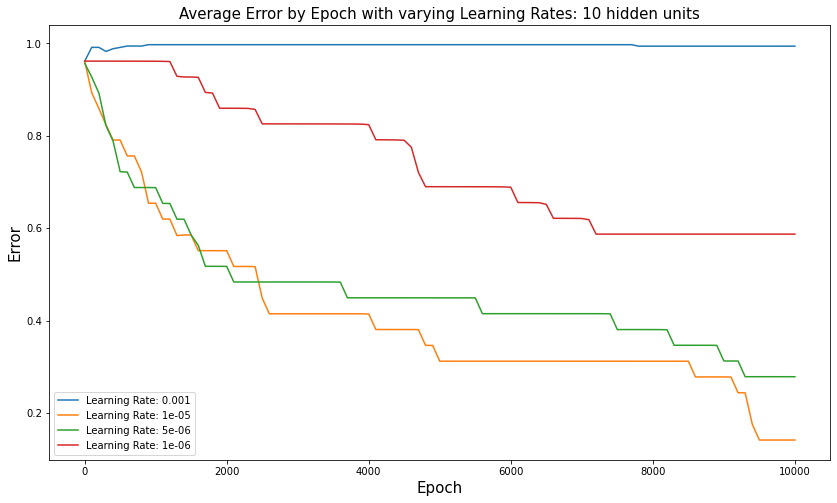



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲1̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
|  0.001   |     0.962     |        3.65%        |
+----------+---------------+---------------------+
|  1e-05   |     0.076     |        3.62%        |
+----------+---------------+---------------------+
|  5e-06   |     0.076     |        4.05%        |
+----------+---------------+---------------------+
|  1e-06   |     0.076     |         3.5%        |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲2̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲0̲0̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.9615383752042528
Error after 5

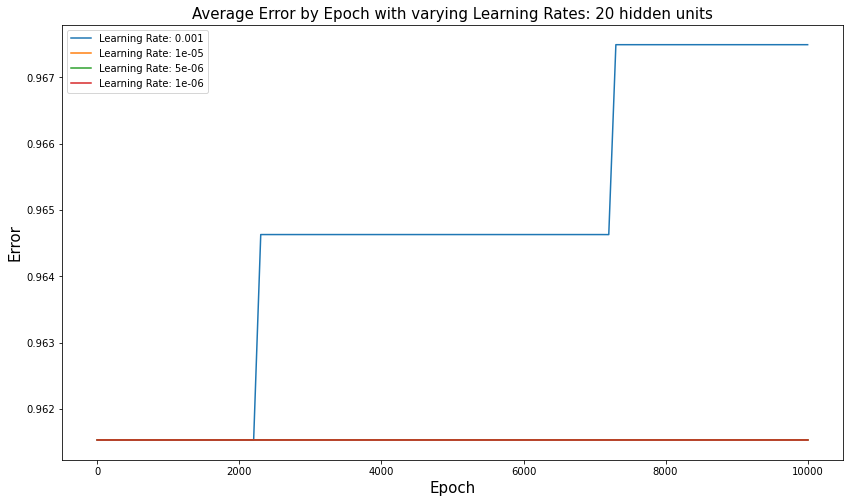



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲2̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
|  0.001   |     1.038     |        3.88%        |
+----------+---------------+---------------------+
|  1e-05   |     0.962     |        3.62%        |
+----------+---------------+---------------------+
|  5e-06   |     0.962     |        4.05%        |
+----------+---------------+---------------------+
|  1e-06   |     0.962     |         3.6%        |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲4̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲R̲a̲n̲d̲o̲m̲l̲y̲ ̲B̲e̲t̲w̲e̲e̲n̲ ̲0̲ ̲a̲n̲d̲ ̲1
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲0̲0̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.9615384615384615
Error after 5

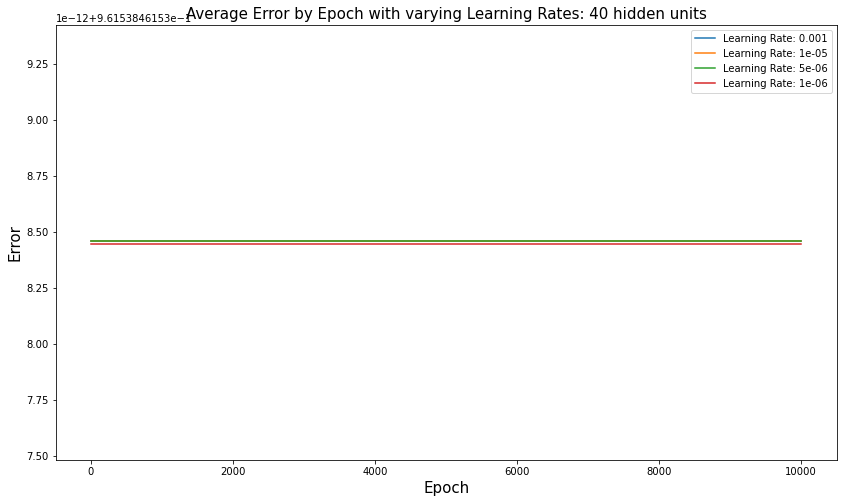



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
|  0.001   |     0.962     |        3.65%        |
+----------+---------------+---------------------+
|  1e-05   |     0.962     |        3.65%        |
+----------+---------------+---------------------+
|  5e-06   |     0.962     |        4.17%        |
+----------+---------------+---------------------+
|  1e-06   |     0.962     |        3.65%        |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------



In [26]:
columns = ["lettr", "xbox", "ybox", "width", "height", "onpix", "xbar", "ybar", "x2bar", "y2bar", "xybar", "x2ybr", 
           "xy2br", "xege", "xegvy", "yege", "yegvx"]
letter_file = pd.read_csv("letter-recognition.data", names=columns)

# randomly assign 80% to training and 20% to testing
# set random_state to be able to reproduce results
train, test = train_test_split(letter_file, test_size=0.2, random_state=8)

target_train = train.pop('lettr')
target_test = test.pop('lettr')

target_output_train = []
target_output_test = []

def convertListFormat(df):
    output = []
    for t in df:
        output_arr = [0]*26
        output_arr[ord(str(t))-ord('A')] = 1
        output.append(output_arr)
    return output

target_output_train = convertListFormat(target_train)
target_output_test = convertListFormat(target_test)    

train = np.array(train)
test = np.array(test)


epochs = 10000
learning_rates = [0.001, 0.00001, 0.000005, 0.000001]
hidden_units = [10, 20, 40]

num_inputs = 16
num_outputs = 26
initialise = 'zero_one'


for hidden_unit in hidden_units:
    evaluate_letter_recognition(num_inputs, num_outputs, train, target_output_train, test, target_output_test, epochs, hidden_unit, learning_rates, target_test.tolist(), initialise)

### Testing with Initialisation of Weights Using Xavier Weight Initialisation

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲1̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲0̲0̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲



<ipython-input-2-e94ae48e2934>:113: RuntimeWarning: overflow encountered in exp
  tanh = (2 / (1 + np.exp(inputMatrix * - 2))) - 1


Error after 100 epochs: 1.014547586613422
Error after 500 epochs: 1.0116201830405023
Error after 1000 epochs: 1.0116201827860956
Error after 2000 epochs: 1.011620182227501
Error after 5000 epochs: 1.0116201800015747
Error after 10000 epochs: 1.0116201719815492

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Correct Predictions: 4.15%
Average Error on Test Set: 0.9615384615348838

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲1̲e̲-̲0̲5
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.07403760346082539
Error after 500 epochs: 0.07464309578001636
Error after 1000 epochs: 0.07480040045097193
Error after 2000 epochs: 0.07077811849658733
Error after 5000 epochs: 0.07018201609888433
Error after 10000 epochs: 0.06783172385174852

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Correct Predictions: 17.15%
Average Error on Test Set: 0.07357216517527501

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲5̲e̲-̲0̲6
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.0740841999171486
Error after 500 epochs: 0.07437565410271628
Error after 1000 epochs: 0.077224806765

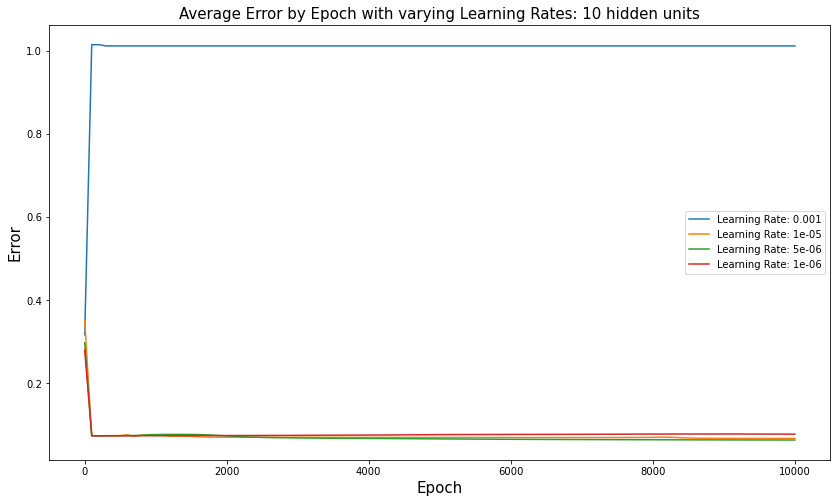



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲1̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
|  0.001   |     0.962     |        4.15%        |
+----------+---------------+---------------------+
|  1e-05   |     0.074     |        17.15%       |
+----------+---------------+---------------------+
|  5e-06   |     0.075     |        27.38%       |
+----------+---------------+---------------------+
|  1e-06   |     0.093     |        32.35%       |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲2̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲0̲0̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.9969951923

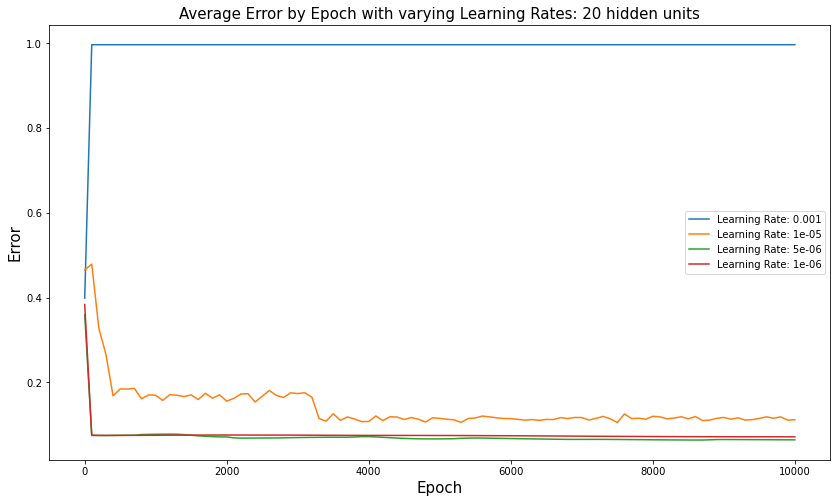



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲2̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
|  0.001   |     1.038     |        4.17%        |
+----------+---------------+---------------------+
|  1e-05   |     0.113     |        30.2%        |
+----------+---------------+---------------------+
|  5e-06   |     0.076     |        38.07%       |
+----------+---------------+---------------------+
|  1e-06   |     0.082     |        28.4%        |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲4̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲0̲.̲0̲0̲1
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.9823942278

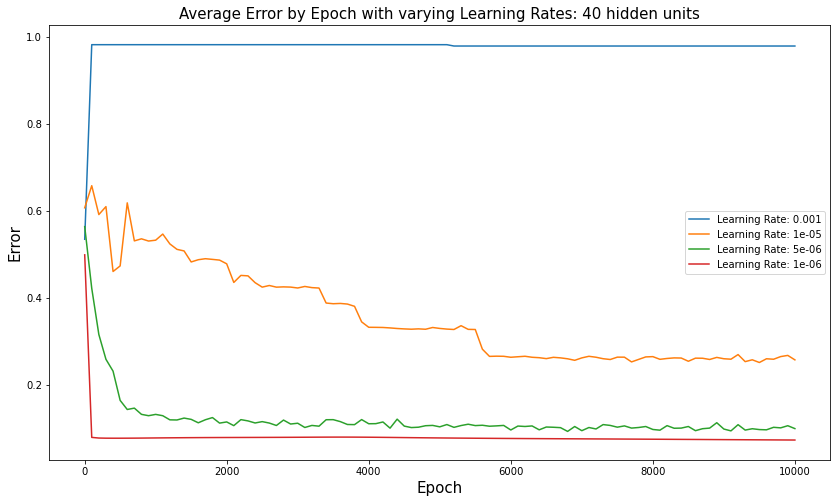



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
|  0.001   |     1.038     |        4.17%        |
+----------+---------------+---------------------+
|  1e-05   |     0.357     |        33.8%        |
+----------+---------------+---------------------+
|  5e-06   |     0.087     |        65.72%       |
+----------+---------------+---------------------+
|  1e-06   |     0.096     |        46.95%       |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------



In [27]:
initialise = 'xavier'
for hidden_unit in hidden_units:
        evaluate_letter_recognition(num_inputs, num_outputs, train, target_output_train, test, target_output_test, epochs, hidden_unit, learning_rates, target_test.tolist(), initialise)

Above it can be seen that the model performed much better using 40 and 50 hidden units and a learning rate of 0.000005. Due to the time it takes to rerun these computations I will now search for optimal hyperparameters close to these values without running the entire set again.

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲3̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲7̲.̲5̲e̲-̲0̲6
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.2617340638086242
Error after 500 epochs: 0.12670470559916694
Error after 1000 epochs: 0.12477264077772603
Error after 2000 epochs: 0.10542691295915459
Error after 5000 epochs: 0.1006544070811989
Error after 10000 epochs: 0.0920484688604942

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Correct Predictions: 62.65%
Average Error on Test Set: 0.07958430047170467

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲5̲e̲-̲0̲6
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.2709532513858294
Error after 500 epochs: 0.16802472841607688
Error after 1000 epochs: 0.13785184170512815
Error after 2000 epochs: 0.13797968541165143
Error after 5000 epochs: 0.10263895840627853
Error after 10000 epochs: 0.07701890869487116

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Correct Predict

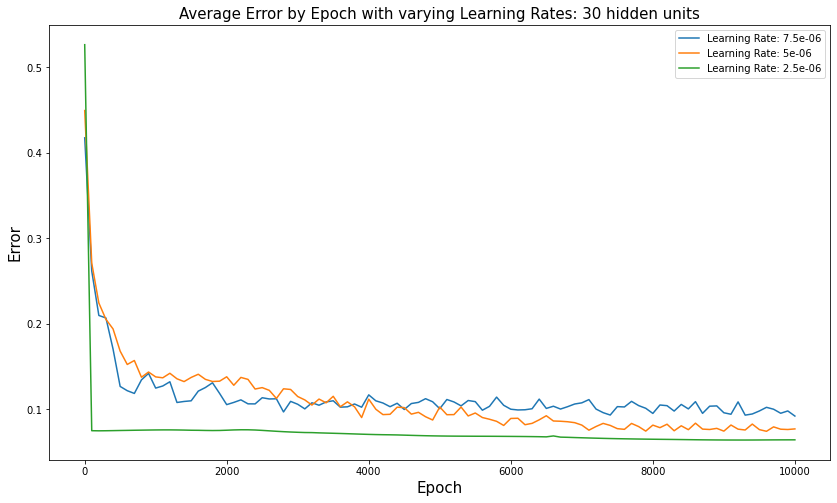



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲3̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
| 7.5e-06  |      0.08     |        62.65%       |
+----------+---------------+---------------------+
|  5e-06   |     0.075     |        54.85%       |
+----------+---------------+---------------------+
| 2.5e-06  |     0.077     |        48.5%        |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲4̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲7̲.̲5̲e̲-̲0̲6
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.4998260620086268
Error after 500 epochs: 0.17812248916793677
Error after 1000 epochs: 0.1750908738062361
Err

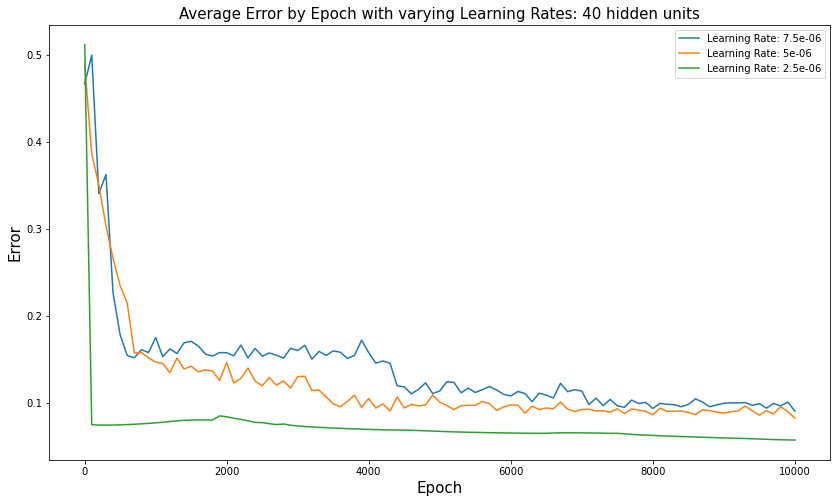



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲4̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
| 7.5e-06  |     0.157     |        70.58%       |
+----------+---------------+---------------------+
|  5e-06   |     0.079     |        67.58%       |
+----------+---------------+---------------------+
| 2.5e-06  |     0.077     |        55.62%       |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲5̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲7̲.̲5̲e̲-̲0̲6
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.47053452117454275
Error after 500 epochs: 0.2964948879790757
Error after 1000 epochs: 0.20584887601586696
Er

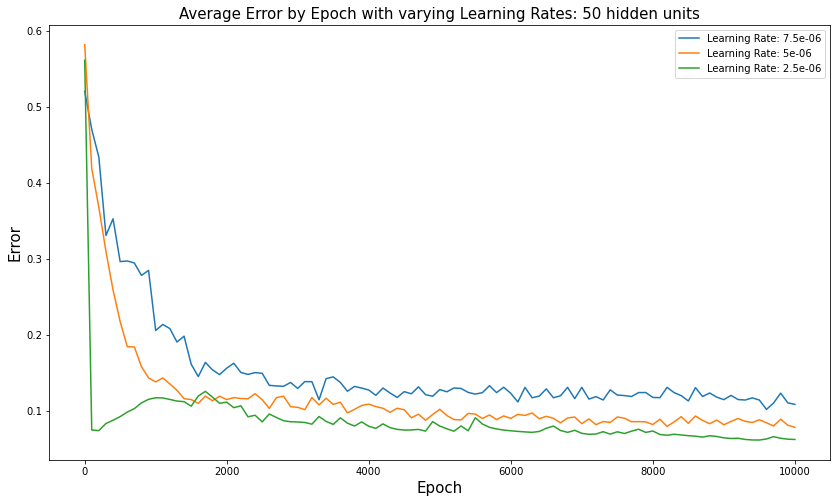



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲5̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
| 7.5e-06  |     0.181     |        68.35%       |
+----------+---------------+---------------------+
|  5e-06   |     0.085     |        70.43%       |
+----------+---------------+---------------------+
| 2.5e-06  |     0.076     |        55.1%        |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲6̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲7̲.̲5̲e̲-̲0̲6
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.7009360924724939
Error after 500 epochs: 0.5265991472177243
Error after 1000 epochs: 0.3121171203009714
Erro

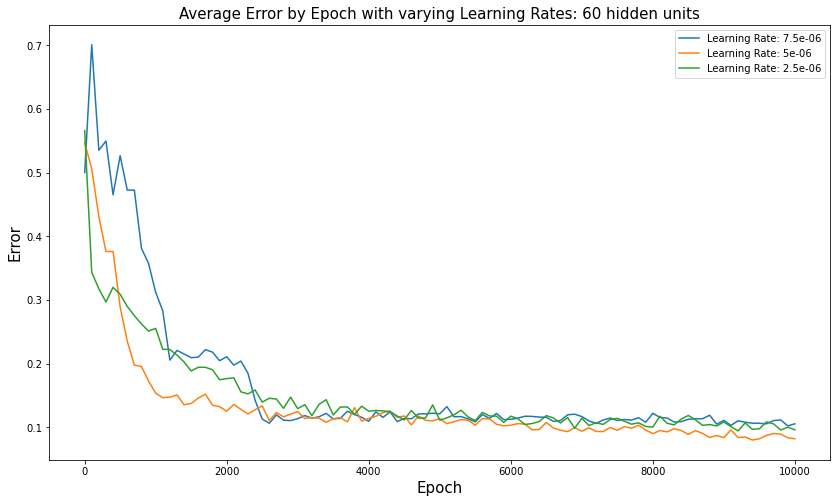



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲6̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
| 7.5e-06  |      0.19     |        70.9%        |
+----------+---------------+---------------------+
|  5e-06   |     0.085     |        74.28%       |
+----------+---------------+---------------------+
| 2.5e-06  |     0.089     |        59.27%       |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------



In [28]:
hidden_units = [30, 40, 50, 60]
learning_rates = [0.0000075, 0.000005, 0.0000025]
initialise = 'xavier'
for hidden_unit in hidden_units:
        evaluate_letter_recognition(num_inputs, num_outputs, train, target_output_train, test, target_output_test, epochs, hidden_unit, learning_rates, target_test.tolist(), initialise)

Given that using 60 hidden units and a learning rate of 0.000005 had an accuracy of over 74%, I will now try to train the model for the final time using 100,000 epochs. I previously noted that a greater number of epochs tends to increase the accuracy, and so it will be interesting to observe if this is the case.

In [31]:
def evaluate_letter_recognition_100(num_inputs, num_outputs, inputs, outputs, testing, testing_outputs, epochs, hidden_units, learning_rates, actual_test_vals, initialise):
    def convert_to_char(np_arr):
        list_arr = list(np_arr)
        index = list_arr.index(max(list_arr))
        # convert to a character based on the index of the highest value in the list
        return chr(index+ord('A'))
    
    table_units = PrettyTable(["Learning (↓) / Epoch (→)", "100", "1000", "10000", "25000", "50000", "100000"])
#     table_units = PrettyTable(["Learning (↓) / Epoch (→)", "100", "500", "1000", "2000", "5000", "10000"])
    table_units_testing = PrettyTable(["Learning", "Average Error", "Correct Predictions"])
    
    # plotting
    x_axis = [x for x in range(100, epochs+1, 100)]
    x_axis.insert(0,1)
    y_axis_arrays = []
    
    with open('image_logs/log_letter_recognition_hidden_' + str(hidden_units) + '_epochs_' + str(epochs) + '_randomise_' + str(initialise)+ '.txt', 'w') as log_file:
        print('****************')
        print("\u0332".join("Hidden Units: " + str(hidden_units)))
        if initialise == 'zero_one':
            print("\u0332".join("Initialising Weights Randomly Between 0 and 1"))
            log_file.write('Initialising Weights Randomly Between 0 and 1\n')
        else:
            print("\u0332".join("Initialising Weights Using Xavier Weight Initialisation"))
            log_file.write('Initialising Weights Using Xavier Weight Initialisation\n')
        print('****************')
        
        log_file.write('Hidden Units: ' + str(hidden_units) + '\n')
        log_file.write('Number of Epochs: ' + str(epochs) + '\n')
        for learning_rate in learning_rates:
            plotting_array = []
            
            table_row = [str(learning_rate)]
            table_row_testing = [str(learning_rate)]
            mlp = MLP(num_inputs, num_outputs, hidden_units)
            mlp.randomise(initialise)
            
            print("\u0332".join("\nLEARNING RATE: " + str(learning_rate)))
            log_file.write('\n****************')
            log_file.write('\nLearning Rate: ' + str(learning_rate) + '\n')
            log_file.write('****************\n')

            print("\u0332".join("Training log:\n"))
            log_file.write('\nTraining log:\n')
            log_file.write('****************\n')

            for i in range(1, epochs+1):
                error = 0
                mlp.forward(np.array(inputs), 'tanh')
                error += mlp.backwards(np.array(outputs), np.array(inputs), 'tanh')
                mlp.update_weights(learning_rate)
                # periodically display error rate
                if i == 100 or i==1000 or i==10000 or i==25000 or i %50000 == 0:
                    table_row.append(str(round(error, 3)))
                    print("Error after", str(i), "epochs:", str(error))
                    log_file.write("Error after " + str(i) + " epochs: " + str(error)+ '\n')
                
                if i % 100 == 0 or i==1:
                    plotting_array.append(error)
            y_axis_arrays.append(plotting_array)

            table_units.add_row(table_row)
            # add line between each row
            table_units.hrules = 1
            print("\u0332".join("\nTesting log:\n"))
            log_file.write('\nTesting log (showing every tenth set of targets/predictions):\n')
            log_file.write('****************')
            testing_predictions = []
            correct_predictions = 0
            for i in range(len(testing)):
                mlp.forward(testing[i], 'tanh')
                char_pred = convert_to_char(mlp.output)
                testing_predictions.append([mlp.output[0]])
                if i % 10 == 0:
                    log_file.write('\nTarget: ' + actual_test_vals[i] + '\n')
                    log_file.write('Prediction: ' + str(char_pred) + '\n')
                if str(char_pred) == actual_test_vals[i]:
                    correct_predictions += 1
                
            testing_error = np.subtract(testing_predictions, testing_outputs)
            testing_ave_error = np.mean(np.abs(testing_error))
            table_row_testing.append(str(round(testing_ave_error, 3)))
            
            correct_predictions = round(correct_predictions/len(testing)*100,2)
            print("Correct Predictions: " + str(correct_predictions)+"%")
            table_row_testing.append(str(correct_predictions)+"%")
            table_units_testing.add_row(table_row_testing)
            # add line between each row
            table_units_testing.hrules = 1
            log_file.write('\nAverage Error on Test Set: ' + str(testing_ave_error) + '\n')
            print("Average Error on Test Set:", testing_ave_error)
            log_file.write('\nCorrectly Predicted: ' + str(correct_predictions) + '% of test set\n')
        log_file.write('\n-----------------------------------------------------------------------------\n')
        
    print("\u0332".join("\nTraining Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units)
    
    print()
    plt.figure(figsize=(14,8))
    for i in range(len(learning_rates)):

        plt.plot(x_axis, y_axis_arrays[i], label="Learning Rate: {:s}".format(str(learning_rates[i])))
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Error", fontsize=15)
    plt.title("Average Error by Epoch with varying Learning Rates: {:s} hidden units".format(str(hidden_units)), fontsize=15)
    plt.legend()
    plt.show()
    print()
    
    print("\u0332".join("\nTesting Results with " + str(hidden_unit) + " hidden units\n"))
    print(table_units_testing)
    
    print('\n-----------------------------------------------------------------------------\n')

****************
H̲i̲d̲d̲e̲n̲ ̲U̲n̲i̲t̲s̲:̲ ̲6̲0
I̲n̲i̲t̲i̲a̲l̲i̲s̲i̲n̲g̲ ̲W̲e̲i̲g̲h̲t̲s̲ ̲U̲s̲i̲n̲g̲ ̲X̲a̲v̲i̲e̲r̲ ̲W̲e̲i̲g̲h̲t̲ ̲I̲n̲i̲t̲i̲a̲l̲i̲s̲a̲t̲i̲o̲n
****************

̲L̲E̲A̲R̲N̲I̲N̲G̲ ̲R̲A̲T̲E̲:̲ ̲5̲e̲-̲0̲6
T̲r̲a̲i̲n̲i̲n̲g̲ ̲l̲o̲g̲:̲

Error after 100 epochs: 0.45922230487768056
Error after 1000 epochs: 0.18265331375658983
Error after 10000 epochs: 0.08508537756211462
Error after 25000 epochs: 0.07699029375004549
Error after 50000 epochs: 0.070260127169575
Error after 100000 epochs: 0.06937641524702694

̲T̲e̲s̲t̲i̲n̲g̲ ̲l̲o̲g̲:̲

Correct Predictions: 76.78%
Average Error on Test Set: 0.08027193627946035

̲T̲r̲a̲i̲n̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲6̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+--------------------------+-------+-------+-------+-------+-------+--------+
| Learning (↓) / Epoch (→) |  100  |  1000 | 10000 | 25000 | 50000 | 100000 |
+--------------------------+-------+-------+-------+-------+-------+--------+
|          5e-06           | 0.459 | 0.183 | 0.085 | 0.077 |  0.07 

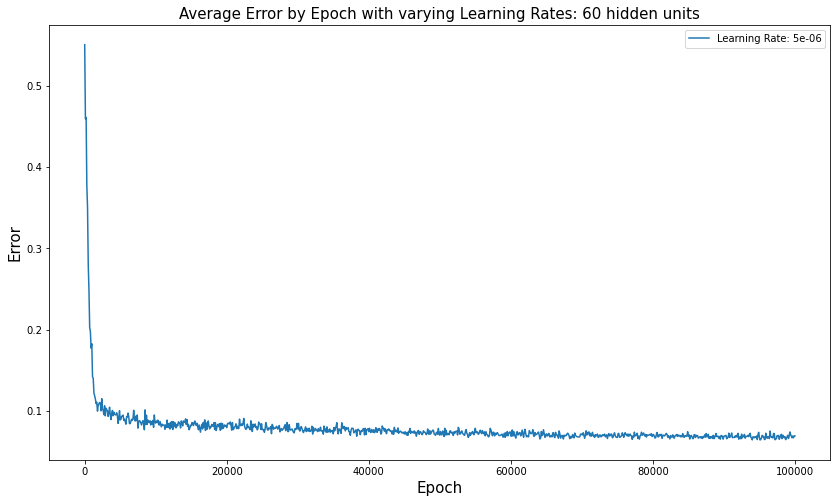



̲T̲e̲s̲t̲i̲n̲g̲ ̲R̲e̲s̲u̲l̲t̲s̲ ̲w̲i̲t̲h̲ ̲6̲0̲ ̲h̲i̲d̲d̲e̲n̲ ̲u̲n̲i̲t̲s̲

+----------+---------------+---------------------+
| Learning | Average Error | Correct Predictions |
+----------+---------------+---------------------+
|  5e-06   |      0.08     |        76.78%       |
+----------+---------------+---------------------+

-----------------------------------------------------------------------------



In [32]:
hidden_units = [60]
learning_rates = [0.000005]
initialise = 'xavier'
epochs = 100000
for hidden_unit in hidden_units:
        evaluate_letter_recognition_100(num_inputs, num_outputs, train, target_output_train, test, target_output_test, epochs, hidden_unit, learning_rates, target_test.tolist(), initialise)